In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import math

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

class DifferentialAttention(nn.Module):
    """
    Differential Attention as described in the Differential Transformer paper
    Following the pseudocode:
    
    def DiffAttn(X, W_q, W_k, W_v, λ):
        Q1, Q2 = split(X @ W_q)
        K1, K2 = split(X @ W_k)
        V = X @ W_v
        # Qi, Ki: [b, n, d]; V: [b, n, 2d]
        s = 1 / sqrt(d)
        A1 = Q1 @ K1.transpose(−1, −2) ∗ s
        A2 = Q2 @ K2.transpose(−1, −2) ∗ s
        return (softmax(A1) − λ softmax(A2)) @ V
    """
    def __init__(self, d_model, d_head, lambda_val=0.5):
        super(DifferentialAttention, self).__init__()
        self.d_head = d_head
        self.scale = 1.0 / math.sqrt(d_head)
        self.lambda_val = lambda_val
        
        # Single projections that will be split into positive/negative parts
        self.q_proj = nn.Linear(d_model, d_head * 2)
        self.k_proj = nn.Linear(d_model, d_head * 2)
        self.v_proj = nn.Linear(d_model, d_head)
    
    def forward(self, x, mask=None):
        # Project and split query and key
        q = self.q_proj(x)  # [batch, seq_len, d_head*2]
        k = self.k_proj(x)  # [batch, seq_len, d_head*2]
        v = self.v_proj(x)  # [batch, seq_len, d_head]
        
        # Split into positive and negative parts
        q1, q2 = torch.chunk(q, 2, dim=-1)  # [batch, seq_len, d_head]
        k1, k2 = torch.chunk(k, 2, dim=-1)  # [batch, seq_len, d_head]
        
        # Calculate attention scores
        attn_scores1 = torch.matmul(q1, k1.transpose(-2, -1)) * self.scale
        attn_scores2 = torch.matmul(q2, k2.transpose(-2, -1)) * self.scale
        
        # Apply mask if provided
        if mask is not None:
            attn_scores1 = attn_scores1.masked_fill(mask == 0, -1e9)
            attn_scores2 = attn_scores2.masked_fill(mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        attn_weights1 = F.softmax(attn_scores1, dim=-1)
        attn_weights2 = F.softmax(attn_scores2, dim=-1)
        
        # Calculate differential attention (positive - λ*negative)
        diff_attn = attn_weights1 - self.lambda_val * attn_weights2
        
        # Apply attention to values
        output = torch.matmul(diff_attn, v)
        
        return output

class MultiHeadDifferentialAttention(nn.Module):
    """
    Multi-Head Differential Attention as described in the paper
    
    Following the pseudocode:
    def MultiHead(X, W_q, W_k, W_v, W_o, λ):
        O = GroupNorm([DiffAttn(X, W_qi, W_ki, W_vi, λ) for i in range(h)])
        O = O ∗ (1 − λinit)
        return Concat(O) @ W_o
    """
    def __init__(self, d_model, num_heads, lambda_init=0.5):
        super(MultiHeadDifferentialAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.lambda_init = lambda_init
        
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_head = d_model // num_heads
        
        # Create multiple differential attention heads
        self.heads = nn.ModuleList([
            DifferentialAttention(d_model, self.d_head, lambda_init)
            for _ in range(num_heads)
        ])
        
        # Use LayerNorm instead of GroupNorm to avoid dimension issues
        # LayerNorm is also typically used in transformers
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Final projection
        self.output_proj = nn.Linear(d_model, d_model)
        
    def forward(self, x, mask=None):
        batch_size = x.shape[0]
        
        # Apply differential attention for each head
        head_outputs = [head(x, mask) for head in self.heads]
        
        # Concatenate outputs from all heads
        multi_head_output = torch.cat(head_outputs, dim=-1)
        
        # Apply layer normalization
        multi_head_output = self.layer_norm(multi_head_output)
        
        # Scale output by (1 - λinit) as mentioned in the paper
        multi_head_output = multi_head_output * (1 - self.lambda_init)
        
        # Final projection
        output = self.output_proj(multi_head_output)
        
        return output

class TransformerEncoderLayer(nn.Module):
    """Transformer Encoder Layer with Differential Attention"""
    def __init__(self, d_model, num_heads, dim_ff, dropout=0.1, lambda_init=0.5):
        super(TransformerEncoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Use differential attention
        self.attention = MultiHeadDifferentialAttention(d_model, num_heads, lambda_init)
        
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_ff, d_model),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Pre-LayerNorm architecture
        attn_output = self.attention(self.norm1(x), mask)
        # Residual connection
        x = x + self.dropout(attn_output)
        
        # Feed forward with residual connection
        ff_output = self.ffn(self.norm2(x))
        x = x + self.dropout(ff_output)
        
        return x

class DifferentialVisionTransformer(nn.Module):
    """
    Vision Transformer with Differential Attention
    """
    def __init__(self, 
                 image_size=32,        # CIFAR-10 image size
                 patch_size=4,         # patch size (2 or 4)
                 in_channels=3,        # RGB images
                 num_classes=10,       # CIFAR-10 has 10 classes
                 d_model=192,          # embedding dimension
                 num_heads=8,          # number of heads in attention
                 num_layers=8,         # number of transformer encoder layers
                 dim_ff=768,           # feed-forward network dimension
                 dropout=0.1,
                 lambda_init=0.5):     # lambda parameter for differential attention
        super(DifferentialVisionTransformer, self).__init__()
        
        # Image and patch parameters
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        
        # Calculate the number of patches
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size
        
        # Linear projection of flattened patches
        self.patch_embedding = nn.Linear(patch_dim, d_model)
        
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        
        # Positional embedding
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, d_model))
        
        # Dropout after position embedding
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder with differential attention
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, dim_ff, dropout, lambda_init)
            for _ in range(num_layers)
        ])
        
        # Layer normalization
        self.norm = nn.LayerNorm(d_model)
        
        # MLP Head for classification
        self.mlp_head = nn.Linear(d_model, num_classes)
        
        # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        # Initialize patch embedding
        nn.init.xavier_uniform_(self.patch_embedding.weight)
        nn.init.zeros_(self.patch_embedding.bias)
        
        # Initialize cls token
        nn.init.normal_(self.cls_token, std=0.02)
        
        # Initialize position embedding
        nn.init.normal_(self.pos_embedding, std=0.02)
        
    def forward(self, x):
        # x shape: [batch_size, channels, height, width]
        batch_size = x.shape[0]
        
        # Extract patches: [B, C, H, W] -> [B, num_patches, C*P*P]
        # Where P is the patch size
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(batch_size, self.in_channels, -1, self.patch_size * self.patch_size)
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.in_channels * self.patch_size * self.patch_size)
        
        # Linear embedding of patches
        x = self.patch_embedding(x)  # [B, num_patches, d_model]
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [B, 1, d_model]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, 1+num_patches, d_model]
        
        # Add positional embedding
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        # Apply transformer encoder layers with differential attention
        for layer in self.encoder_layers:
            x = layer(x)
        
        # Apply layer normalization
        x = self.norm(x)
        
        # Take the cls token representation
        x = x[:, 0]  # [B, d_model]
        
        # Classification head
        x = self.mlp_head(x)  # [B, num_classes]
        
        return x

def get_data_loaders(batch_size=128):
    """Create CIFAR-10 dataloaders"""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Create a validation set
    val_size = 5000
    train_size = len(trainset) - val_size
    
    train_subset, val_subset = torch.utils.data.random_split(
        trainset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(42))
    
    valloader = DataLoader(
        val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    train_subset_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    return train_subset_loader, valloader, testloader

def train_model(model, train_loader, val_loader, epochs=30, lr=3e-4, weight_decay=1e-4, model_name='diff_vit'):
    """Train the Differential Vision Transformer model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # For tracking metrics
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    # For saving the best model
    best_val_acc = 0
    best_model_path = f'best_model_{model_name}.pth'
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({
                'loss': train_loss/(batch_idx+1), 
                'acc': 100.*correct/total
            })
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                pbar.set_postfix({
                    'loss': val_loss/(batch_idx+1), 
                    'acc': 100.*correct/total
                })
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print stats
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        
        # Save the best model
        if val_acc > best_val_acc:
            print(f'Validation accuracy improved from {best_val_acc:.2f}% to {val_acc:.2f}%, saving model...')
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
        
        # Update learning rate
        scheduler.step()
    
    print(f'Best validation accuracy: {best_val_acc:.2f}%')
    return train_losses, train_accs, val_losses, val_accs

def evaluate_model(model, test_loader):
    """Evaluate the trained model on the test set"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Evaluating on test set'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_acc = 100. * correct / total
    print(f'Test accuracy: {test_acc:.2f}%')
    return test_acc

def plot_metrics(train_losses, val_losses, train_accs, val_accs, title_suffix="", filename_prefix="diff_vit"):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss{title_suffix}')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training and Validation Accuracy{title_suffix}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_metrics.png')
    plt.show()


Setting up Differential Vision Transformer hyperparameter tuning...


100%|██████████| 170M/170M [00:03<00:00, 47.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

--- Running configuration diff_set1 ---
diff_set1: 4.18M parameters
Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.11it/s, loss=1.54, acc=43.8]


Epoch 1/50:
Train Loss: 1.7794 | Train Acc: 33.70%
Val Loss: 1.5359 | Val Acc: 43.78%
Validation accuracy improved from 0.00% to 43.78%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.26it/s, loss=1.42, acc=48.3]


Epoch 2/50:
Train Loss: 1.4768 | Train Acc: 45.93%
Val Loss: 1.4173 | Val Acc: 48.28%
Validation accuracy improved from 43.78% to 48.28%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.25it/s, loss=1.24, acc=54.7]


Epoch 3/50:
Train Loss: 1.3249 | Train Acc: 51.75%
Val Loss: 1.2396 | Val Acc: 54.66%
Validation accuracy improved from 48.28% to 54.66%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.17it/s, loss=1.15, acc=58.3]


Epoch 4/50:
Train Loss: 1.2328 | Train Acc: 55.27%
Val Loss: 1.1534 | Val Acc: 58.26%
Validation accuracy improved from 54.66% to 58.26%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.66it/s, loss=1.12, acc=59.2]


Epoch 5/50:
Train Loss: 1.1565 | Train Acc: 57.90%
Val Loss: 1.1241 | Val Acc: 59.18%
Validation accuracy improved from 58.26% to 59.18%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.59it/s, loss=1.08, acc=60.6]


Epoch 6/50:
Train Loss: 1.1020 | Train Acc: 60.14%
Val Loss: 1.0829 | Val Acc: 60.58%
Validation accuracy improved from 59.18% to 60.58%, saving model...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.60it/s, loss=1.01, acc=63.7]


Epoch 7/50:
Train Loss: 1.0538 | Train Acc: 62.02%
Val Loss: 1.0109 | Val Acc: 63.72%
Validation accuracy improved from 60.58% to 63.72%, saving model...


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.18it/s, loss=0.971, acc=64.5]


Epoch 8/50:
Train Loss: 1.0113 | Train Acc: 63.82%
Val Loss: 0.9707 | Val Acc: 64.50%
Validation accuracy improved from 63.72% to 64.50%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.07it/s, loss=0.96, acc=65.5]


Epoch 9/50:
Train Loss: 0.9631 | Train Acc: 65.54%
Val Loss: 0.9598 | Val Acc: 65.54%
Validation accuracy improved from 64.50% to 65.54%, saving model...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.17it/s, loss=0.929, acc=67.1]


Epoch 10/50:
Train Loss: 0.9249 | Train Acc: 66.86%
Val Loss: 0.9287 | Val Acc: 67.14%
Validation accuracy improved from 65.54% to 67.14%, saving model...


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.68it/s, loss=0.874, acc=68.7]


Epoch 11/50:
Train Loss: 0.8890 | Train Acc: 68.25%
Val Loss: 0.8743 | Val Acc: 68.74%
Validation accuracy improved from 67.14% to 68.74%, saving model...


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.44it/s, loss=0.846, acc=69.5]


Epoch 12/50:
Train Loss: 0.8653 | Train Acc: 69.16%
Val Loss: 0.8457 | Val Acc: 69.54%
Validation accuracy improved from 68.74% to 69.54%, saving model...


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.39it/s, loss=0.827, acc=70.4]


Epoch 13/50:
Train Loss: 0.8339 | Train Acc: 69.97%
Val Loss: 0.8267 | Val Acc: 70.38%
Validation accuracy improved from 69.54% to 70.38%, saving model...


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.86it/s, loss=0.856, acc=70.6]


Epoch 14/50:
Train Loss: 0.8021 | Train Acc: 71.22%
Val Loss: 0.8560 | Val Acc: 70.62%
Validation accuracy improved from 70.38% to 70.62%, saving model...


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.65it/s, loss=0.809, acc=71.7]


Epoch 15/50:
Train Loss: 0.7763 | Train Acc: 72.36%
Val Loss: 0.8094 | Val Acc: 71.72%
Validation accuracy improved from 70.62% to 71.72%, saving model...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.77it/s, loss=0.769, acc=73.1]


Epoch 16/50:
Train Loss: 0.7426 | Train Acc: 73.47%
Val Loss: 0.7694 | Val Acc: 73.14%
Validation accuracy improved from 71.72% to 73.14%, saving model...


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.68it/s, loss=0.774, acc=72.6]


Epoch 17/50:
Train Loss: 0.7171 | Train Acc: 74.57%
Val Loss: 0.7741 | Val Acc: 72.64%


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.09it/s, loss=0.752, acc=74.1]


Epoch 18/50:
Train Loss: 0.6931 | Train Acc: 75.35%
Val Loss: 0.7518 | Val Acc: 74.12%
Validation accuracy improved from 73.14% to 74.12%, saving model...


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.83it/s, loss=0.725, acc=74.3]


Epoch 19/50:
Train Loss: 0.6693 | Train Acc: 76.12%
Val Loss: 0.7253 | Val Acc: 74.32%
Validation accuracy improved from 74.12% to 74.32%, saving model...


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.08it/s, loss=0.733, acc=75]


Epoch 20/50:
Train Loss: 0.6511 | Train Acc: 76.89%
Val Loss: 0.7334 | Val Acc: 74.96%
Validation accuracy improved from 74.32% to 74.96%, saving model...


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.02it/s, loss=0.756, acc=73.6]


Epoch 21/50:
Train Loss: 0.6230 | Train Acc: 77.81%
Val Loss: 0.7556 | Val Acc: 73.62%


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.52it/s, loss=0.72, acc=74.8]


Epoch 22/50:
Train Loss: 0.6000 | Train Acc: 78.52%
Val Loss: 0.7201 | Val Acc: 74.76%


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.75it/s, loss=0.732, acc=75.4]


Epoch 23/50:
Train Loss: 0.5816 | Train Acc: 79.28%
Val Loss: 0.7322 | Val Acc: 75.40%
Validation accuracy improved from 74.96% to 75.40%, saving model...


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.09it/s, loss=0.687, acc=76.5]


Epoch 24/50:
Train Loss: 0.5588 | Train Acc: 79.99%
Val Loss: 0.6867 | Val Acc: 76.46%
Validation accuracy improved from 75.40% to 76.46%, saving model...


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.14it/s, loss=0.723, acc=75.3]


Epoch 25/50:
Train Loss: 0.5400 | Train Acc: 80.81%
Val Loss: 0.7231 | Val Acc: 75.30%


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.63it/s, loss=0.702, acc=75.9]


Epoch 26/50:
Train Loss: 0.5192 | Train Acc: 81.43%
Val Loss: 0.7020 | Val Acc: 75.92%


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.52it/s, loss=0.661, acc=77.9]


Epoch 27/50:
Train Loss: 0.4957 | Train Acc: 82.24%
Val Loss: 0.6607 | Val Acc: 77.90%
Validation accuracy improved from 76.46% to 77.90%, saving model...


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.15it/s, loss=0.693, acc=76.8]


Epoch 28/50:
Train Loss: 0.4752 | Train Acc: 83.07%
Val Loss: 0.6935 | Val Acc: 76.84%


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.29it/s, loss=0.692, acc=77]


Epoch 29/50:
Train Loss: 0.4592 | Train Acc: 83.70%
Val Loss: 0.6924 | Val Acc: 77.00%


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.09it/s, loss=0.679, acc=77.6]


Epoch 30/50:
Train Loss: 0.4447 | Train Acc: 84.05%
Val Loss: 0.6788 | Val Acc: 77.60%


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.95it/s, loss=0.705, acc=77.6]


Epoch 31/50:
Train Loss: 0.4262 | Train Acc: 84.71%
Val Loss: 0.7050 | Val Acc: 77.62%


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.37it/s, loss=0.705, acc=77.5]


Epoch 32/50:
Train Loss: 0.4085 | Train Acc: 85.34%
Val Loss: 0.7050 | Val Acc: 77.46%


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.42it/s, loss=0.713, acc=77.8]


Epoch 33/50:
Train Loss: 0.3950 | Train Acc: 85.84%
Val Loss: 0.7133 | Val Acc: 77.84%


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.37it/s, loss=0.704, acc=77.7]


Epoch 34/50:
Train Loss: 0.3775 | Train Acc: 86.49%
Val Loss: 0.7039 | Val Acc: 77.66%


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.93it/s, loss=0.712, acc=77.2]


Epoch 35/50:
Train Loss: 0.3603 | Train Acc: 87.14%
Val Loss: 0.7124 | Val Acc: 77.18%


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.34it/s, loss=0.757, acc=77.8]


Epoch 36/50:
Train Loss: 0.3452 | Train Acc: 87.44%
Val Loss: 0.7566 | Val Acc: 77.84%


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.20it/s, loss=0.71, acc=78.3]


Epoch 37/50:
Train Loss: 0.3383 | Train Acc: 87.89%
Val Loss: 0.7105 | Val Acc: 78.26%
Validation accuracy improved from 77.90% to 78.26%, saving model...


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.20it/s, loss=0.702, acc=78.8]


Epoch 38/50:
Train Loss: 0.3214 | Train Acc: 88.46%
Val Loss: 0.7018 | Val Acc: 78.76%
Validation accuracy improved from 78.26% to 78.76%, saving model...


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.19it/s, loss=0.749, acc=78]


Epoch 39/50:
Train Loss: 0.3146 | Train Acc: 88.69%
Val Loss: 0.7485 | Val Acc: 77.96%


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.12it/s, loss=0.709, acc=79.3]


Epoch 40/50:
Train Loss: 0.3019 | Train Acc: 89.32%
Val Loss: 0.7092 | Val Acc: 79.30%
Validation accuracy improved from 78.76% to 79.30%, saving model...


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.44it/s, loss=0.733, acc=78.6]


Epoch 41/50:
Train Loss: 0.2877 | Train Acc: 89.84%
Val Loss: 0.7335 | Val Acc: 78.56%


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.56it/s, loss=0.74, acc=78.1]


Epoch 42/50:
Train Loss: 0.2854 | Train Acc: 89.86%
Val Loss: 0.7402 | Val Acc: 78.08%


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.08it/s, loss=0.742, acc=78.4]


Epoch 43/50:
Train Loss: 0.2771 | Train Acc: 90.12%
Val Loss: 0.7422 | Val Acc: 78.36%


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 24.16it/s, loss=0.745, acc=78.1]


Epoch 44/50:
Train Loss: 0.2688 | Train Acc: 90.47%
Val Loss: 0.7447 | Val Acc: 78.10%


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.82it/s, loss=0.742, acc=78.8]


Epoch 45/50:
Train Loss: 0.2666 | Train Acc: 90.54%
Val Loss: 0.7420 | Val Acc: 78.82%


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.29it/s, loss=0.734, acc=78.6]


Epoch 46/50:
Train Loss: 0.2643 | Train Acc: 90.57%
Val Loss: 0.7336 | Val Acc: 78.64%


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.02it/s, loss=0.75, acc=78.7]


Epoch 47/50:
Train Loss: 0.2625 | Train Acc: 90.58%
Val Loss: 0.7495 | Val Acc: 78.68%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.71it/s, loss=0.783, acc=77.9]


Epoch 48/50:
Train Loss: 0.2588 | Train Acc: 90.83%
Val Loss: 0.7832 | Val Acc: 77.94%


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.80it/s, loss=0.778, acc=77.7]


Epoch 49/50:
Train Loss: 0.2573 | Train Acc: 90.88%
Val Loss: 0.7783 | Val Acc: 77.68%


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.09it/s, loss=0.77, acc=78.3]
/tmp/ipykernel_19/1762310108.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bes

Epoch 50/50:
Train Loss: 0.2547 | Train Acc: 90.89%
Val Loss: 0.7703 | Val Acc: 78.28%
Best validation accuracy: 79.30%
Loading best model for evaluation...


Evaluating on test set: 100%|██████████| 79/79 [00:03<00:00, 25.58it/s]


Test accuracy: 79.64%
Final test accuracy: 79.64%
Plotting metrics...


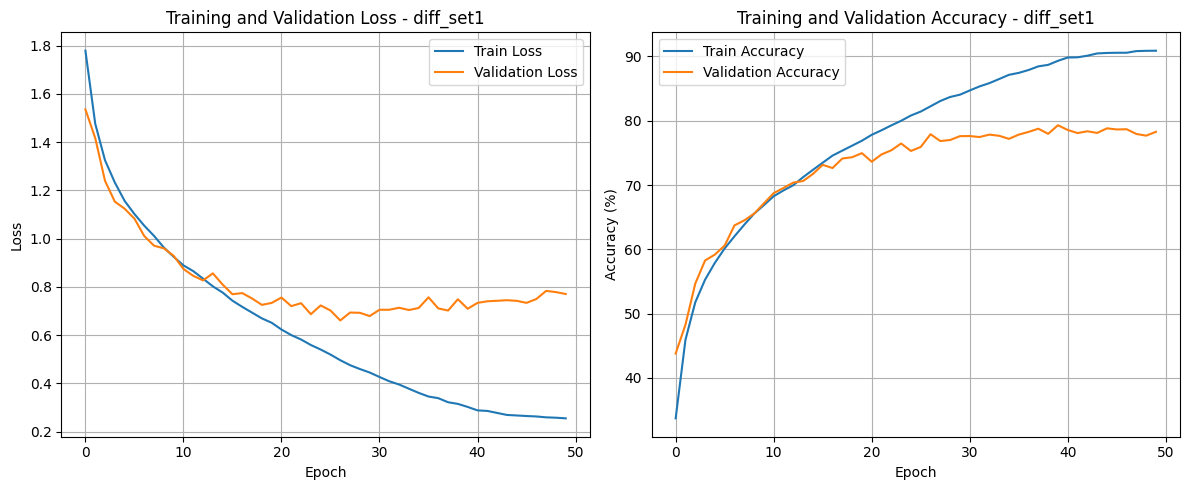


--- Running configuration diff_set2 ---
diff_set2: 4.20M parameters
Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.66it/s, loss=1.66, acc=37.4]


Epoch 1/50:
Train Loss: 1.8264 | Train Acc: 31.53%
Val Loss: 1.6553 | Val Acc: 37.42%
Validation accuracy improved from 0.00% to 37.42%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 24.53it/s, loss=1.51, acc=45.5]


Epoch 2/50:
Train Loss: 1.5959 | Train Acc: 40.74%
Val Loss: 1.5095 | Val Acc: 45.46%
Validation accuracy improved from 37.42% to 45.46%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.73it/s, loss=1.42, acc=47.5]


Epoch 3/50:
Train Loss: 1.4847 | Train Acc: 45.73%
Val Loss: 1.4189 | Val Acc: 47.54%
Validation accuracy improved from 45.46% to 47.54%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.53it/s, loss=1.35, acc=50.6]


Epoch 4/50:
Train Loss: 1.4068 | Train Acc: 48.72%
Val Loss: 1.3517 | Val Acc: 50.62%
Validation accuracy improved from 47.54% to 50.62%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.25it/s, loss=1.28, acc=54]


Epoch 5/50:
Train Loss: 1.3423 | Train Acc: 51.31%
Val Loss: 1.2805 | Val Acc: 53.98%
Validation accuracy improved from 50.62% to 53.98%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.62it/s, loss=1.27, acc=53.3]


Epoch 6/50:
Train Loss: 1.2906 | Train Acc: 53.38%
Val Loss: 1.2737 | Val Acc: 53.34%


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.84it/s, loss=1.22, acc=56]


Epoch 7/50:
Train Loss: 1.2442 | Train Acc: 54.79%
Val Loss: 1.2152 | Val Acc: 56.02%
Validation accuracy improved from 53.98% to 56.02%, saving model...


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.48it/s, loss=1.19, acc=56.4]


Epoch 8/50:
Train Loss: 1.2065 | Train Acc: 56.22%
Val Loss: 1.1901 | Val Acc: 56.36%
Validation accuracy improved from 56.02% to 56.36%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.10it/s, loss=1.17, acc=57.7]


Epoch 9/50:
Train Loss: 1.1721 | Train Acc: 57.72%
Val Loss: 1.1702 | Val Acc: 57.70%
Validation accuracy improved from 56.36% to 57.70%, saving model...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.24it/s, loss=1.13, acc=60]


Epoch 10/50:
Train Loss: 1.1426 | Train Acc: 58.72%
Val Loss: 1.1278 | Val Acc: 60.00%
Validation accuracy improved from 57.70% to 60.00%, saving model...


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.14it/s, loss=1.06, acc=62.2]


Epoch 11/50:
Train Loss: 1.1039 | Train Acc: 60.36%
Val Loss: 1.0646 | Val Acc: 62.24%
Validation accuracy improved from 60.00% to 62.24%, saving model...


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.78it/s, loss=1.08, acc=61.3]


Epoch 12/50:
Train Loss: 1.0778 | Train Acc: 61.17%
Val Loss: 1.0755 | Val Acc: 61.26%


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.67it/s, loss=1.04, acc=62.2]


Epoch 13/50:
Train Loss: 1.0489 | Train Acc: 62.22%
Val Loss: 1.0383 | Val Acc: 62.18%


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.10it/s, loss=1.03, acc=62.6]


Epoch 14/50:
Train Loss: 1.0215 | Train Acc: 63.37%
Val Loss: 1.0331 | Val Acc: 62.62%
Validation accuracy improved from 62.24% to 62.62%, saving model...


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.07it/s, loss=1.03, acc=63.4]


Epoch 15/50:
Train Loss: 0.9984 | Train Acc: 64.02%
Val Loss: 1.0272 | Val Acc: 63.38%
Validation accuracy improved from 62.62% to 63.38%, saving model...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.30it/s, loss=1, acc=64.6]


Epoch 16/50:
Train Loss: 0.9737 | Train Acc: 65.00%
Val Loss: 1.0035 | Val Acc: 64.60%
Validation accuracy improved from 63.38% to 64.60%, saving model...


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.42it/s, loss=0.966, acc=65.7]


Epoch 17/50:
Train Loss: 0.9554 | Train Acc: 65.82%
Val Loss: 0.9658 | Val Acc: 65.70%
Validation accuracy improved from 64.60% to 65.70%, saving model...


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.44it/s, loss=0.942, acc=66.9]


Epoch 18/50:
Train Loss: 0.9334 | Train Acc: 66.80%
Val Loss: 0.9417 | Val Acc: 66.92%
Validation accuracy improved from 65.70% to 66.92%, saving model...


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.66it/s, loss=0.958, acc=66.3]


Epoch 19/50:
Train Loss: 0.9047 | Train Acc: 67.70%
Val Loss: 0.9580 | Val Acc: 66.30%


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.44it/s, loss=0.969, acc=66.3]


Epoch 20/50:
Train Loss: 0.8826 | Train Acc: 68.31%
Val Loss: 0.9687 | Val Acc: 66.34%


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.60it/s, loss=0.906, acc=68]


Epoch 21/50:
Train Loss: 0.8685 | Train Acc: 69.04%
Val Loss: 0.9059 | Val Acc: 67.98%
Validation accuracy improved from 66.92% to 67.98%, saving model...


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.81it/s, loss=0.883, acc=68.5]


Epoch 22/50:
Train Loss: 0.8464 | Train Acc: 69.75%
Val Loss: 0.8832 | Val Acc: 68.48%
Validation accuracy improved from 67.98% to 68.48%, saving model...


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.97it/s, loss=0.884, acc=68.7]


Epoch 23/50:
Train Loss: 0.8242 | Train Acc: 70.56%
Val Loss: 0.8841 | Val Acc: 68.70%
Validation accuracy improved from 68.48% to 68.70%, saving model...


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.75it/s, loss=0.875, acc=68.9]


Epoch 24/50:
Train Loss: 0.8089 | Train Acc: 70.92%
Val Loss: 0.8751 | Val Acc: 68.88%
Validation accuracy improved from 68.70% to 68.88%, saving model...


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.46it/s, loss=0.879, acc=69.5]


Epoch 25/50:
Train Loss: 0.7933 | Train Acc: 71.66%
Val Loss: 0.8790 | Val Acc: 69.48%
Validation accuracy improved from 68.88% to 69.48%, saving model...


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.96it/s, loss=0.878, acc=69.5]


Epoch 26/50:
Train Loss: 0.7725 | Train Acc: 72.56%
Val Loss: 0.8781 | Val Acc: 69.48%


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.74it/s, loss=0.857, acc=69.5]


Epoch 27/50:
Train Loss: 0.7565 | Train Acc: 73.10%
Val Loss: 0.8570 | Val Acc: 69.54%
Validation accuracy improved from 69.48% to 69.54%, saving model...


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.19it/s, loss=0.834, acc=70.9]


Epoch 28/50:
Train Loss: 0.7448 | Train Acc: 73.57%
Val Loss: 0.8337 | Val Acc: 70.92%
Validation accuracy improved from 69.54% to 70.92%, saving model...


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.24it/s, loss=0.83, acc=71]


Epoch 29/50:
Train Loss: 0.7294 | Train Acc: 74.16%
Val Loss: 0.8304 | Val Acc: 71.00%
Validation accuracy improved from 70.92% to 71.00%, saving model...


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.76it/s, loss=0.835, acc=71.9]


Epoch 30/50:
Train Loss: 0.7082 | Train Acc: 74.94%
Val Loss: 0.8351 | Val Acc: 71.92%
Validation accuracy improved from 71.00% to 71.92%, saving model...


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.54it/s, loss=0.826, acc=71.2]


Epoch 31/50:
Train Loss: 0.6961 | Train Acc: 75.24%
Val Loss: 0.8258 | Val Acc: 71.20%


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.10it/s, loss=0.821, acc=71.5]


Epoch 32/50:
Train Loss: 0.6812 | Train Acc: 75.82%
Val Loss: 0.8211 | Val Acc: 71.50%


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 24.69it/s, loss=0.79, acc=72.6]


Epoch 33/50:
Train Loss: 0.6668 | Train Acc: 76.14%
Val Loss: 0.7903 | Val Acc: 72.64%
Validation accuracy improved from 71.92% to 72.64%, saving model...


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.14it/s, loss=0.812, acc=71.8]


Epoch 34/50:
Train Loss: 0.6524 | Train Acc: 76.58%
Val Loss: 0.8117 | Val Acc: 71.82%


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.14it/s, loss=0.831, acc=71.9]


Epoch 35/50:
Train Loss: 0.6414 | Train Acc: 77.07%
Val Loss: 0.8310 | Val Acc: 71.92%


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.59it/s, loss=0.809, acc=72.3]


Epoch 36/50:
Train Loss: 0.6340 | Train Acc: 77.18%
Val Loss: 0.8089 | Val Acc: 72.26%


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.03it/s, loss=0.809, acc=72.7]


Epoch 37/50:
Train Loss: 0.6237 | Train Acc: 77.63%
Val Loss: 0.8087 | Val Acc: 72.68%
Validation accuracy improved from 72.64% to 72.68%, saving model...


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.88it/s, loss=0.806, acc=72.1]


Epoch 38/50:
Train Loss: 0.6130 | Train Acc: 78.08%
Val Loss: 0.8057 | Val Acc: 72.14%


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.95it/s, loss=0.797, acc=72.7]


Epoch 39/50:
Train Loss: 0.6041 | Train Acc: 78.34%
Val Loss: 0.7967 | Val Acc: 72.70%
Validation accuracy improved from 72.68% to 72.70%, saving model...


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.16it/s, loss=0.808, acc=72.4]


Epoch 40/50:
Train Loss: 0.5974 | Train Acc: 78.72%
Val Loss: 0.8084 | Val Acc: 72.40%


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.65it/s, loss=0.809, acc=72.5]


Epoch 41/50:
Train Loss: 0.5904 | Train Acc: 78.85%
Val Loss: 0.8093 | Val Acc: 72.48%


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.25it/s, loss=0.798, acc=73.2]


Epoch 42/50:
Train Loss: 0.5841 | Train Acc: 79.16%
Val Loss: 0.7976 | Val Acc: 73.22%
Validation accuracy improved from 72.70% to 73.22%, saving model...


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.28it/s, loss=0.789, acc=73.4]


Epoch 43/50:
Train Loss: 0.5764 | Train Acc: 79.32%
Val Loss: 0.7888 | Val Acc: 73.36%
Validation accuracy improved from 73.22% to 73.36%, saving model...


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.01it/s, loss=0.79, acc=73]


Epoch 44/50:
Train Loss: 0.5724 | Train Acc: 79.52%
Val Loss: 0.7901 | Val Acc: 73.00%


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.26it/s, loss=0.82, acc=72.8]


Epoch 45/50:
Train Loss: 0.5673 | Train Acc: 79.66%
Val Loss: 0.8197 | Val Acc: 72.80%


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.18it/s, loss=0.806, acc=73.2]


Epoch 46/50:
Train Loss: 0.5682 | Train Acc: 79.53%
Val Loss: 0.8058 | Val Acc: 73.22%


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.85it/s, loss=0.806, acc=73.3]


Epoch 47/50:
Train Loss: 0.5659 | Train Acc: 79.62%
Val Loss: 0.8058 | Val Acc: 73.30%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.83it/s, loss=0.777, acc=74.1]


Epoch 48/50:
Train Loss: 0.5623 | Train Acc: 79.98%
Val Loss: 0.7770 | Val Acc: 74.06%
Validation accuracy improved from 73.36% to 74.06%, saving model...


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.41it/s, loss=0.807, acc=74.1]


Epoch 49/50:
Train Loss: 0.5609 | Train Acc: 79.91%
Val Loss: 0.8073 | Val Acc: 74.06%


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.03it/s, loss=0.786, acc=73.9]


Epoch 50/50:
Train Loss: 0.5575 | Train Acc: 79.96%
Val Loss: 0.7863 | Val Acc: 73.88%
Best validation accuracy: 74.06%
Loading best model for evaluation...


Evaluating on test set: 100%|██████████| 79/79 [00:01<00:00, 40.98it/s]


Test accuracy: 73.68%
Final test accuracy: 73.68%
Plotting metrics...


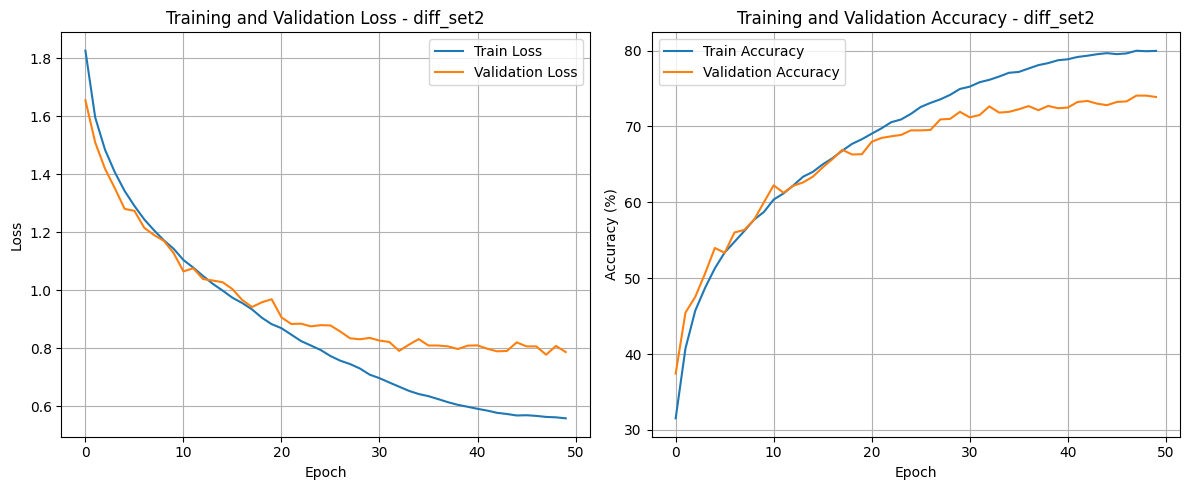


--- Running configuration diff_set3 ---
diff_set3: 1.41M parameters
Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 32.36it/s, loss=1.6, acc=41.4]


Epoch 1/50:
Train Loss: 1.7835 | Train Acc: 33.29%
Val Loss: 1.6033 | Val Acc: 41.36%
Validation accuracy improved from 0.00% to 41.36%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 32.35it/s, loss=1.4, acc=49.2]


Epoch 2/50:
Train Loss: 1.5166 | Train Acc: 44.54%
Val Loss: 1.4001 | Val Acc: 49.18%
Validation accuracy improved from 41.36% to 49.18%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.82it/s, loss=1.29, acc=52.3]


Epoch 3/50:
Train Loss: 1.3868 | Train Acc: 49.26%
Val Loss: 1.2884 | Val Acc: 52.34%
Validation accuracy improved from 49.18% to 52.34%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.58it/s, loss=1.22, acc=55.1]


Epoch 4/50:
Train Loss: 1.2916 | Train Acc: 53.06%
Val Loss: 1.2186 | Val Acc: 55.06%
Validation accuracy improved from 52.34% to 55.06%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 32.69it/s, loss=1.2, acc=56.4]


Epoch 5/50:
Train Loss: 1.2201 | Train Acc: 55.91%
Val Loss: 1.2019 | Val Acc: 56.44%
Validation accuracy improved from 55.06% to 56.44%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 32.64it/s, loss=1.09, acc=60.6]


Epoch 6/50:
Train Loss: 1.1734 | Train Acc: 57.61%
Val Loss: 1.0923 | Val Acc: 60.64%
Validation accuracy improved from 56.44% to 60.64%, saving model...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.31it/s, loss=1.12, acc=59.4]


Epoch 7/50:
Train Loss: 1.1305 | Train Acc: 59.49%
Val Loss: 1.1216 | Val Acc: 59.40%


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 32.69it/s, loss=1.04, acc=62.1]


Epoch 8/50:
Train Loss: 1.0863 | Train Acc: 61.12%
Val Loss: 1.0410 | Val Acc: 62.10%
Validation accuracy improved from 60.64% to 62.10%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.02it/s, loss=1.02, acc=63.5]


Epoch 9/50:
Train Loss: 1.0534 | Train Acc: 62.08%
Val Loss: 1.0214 | Val Acc: 63.52%
Validation accuracy improved from 62.10% to 63.52%, saving model...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 32.80it/s, loss=0.975, acc=65.2]


Epoch 10/50:
Train Loss: 1.0231 | Train Acc: 63.17%
Val Loss: 0.9748 | Val Acc: 65.20%
Validation accuracy improved from 63.52% to 65.20%, saving model...


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.12it/s, loss=0.988, acc=64.7]


Epoch 11/50:
Train Loss: 0.9965 | Train Acc: 63.92%
Val Loss: 0.9880 | Val Acc: 64.70%


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.52it/s, loss=0.947, acc=66.1]


Epoch 12/50:
Train Loss: 0.9620 | Train Acc: 65.52%
Val Loss: 0.9475 | Val Acc: 66.08%
Validation accuracy improved from 65.20% to 66.08%, saving model...


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 32.76it/s, loss=0.922, acc=67.3]


Epoch 13/50:
Train Loss: 0.9344 | Train Acc: 66.35%
Val Loss: 0.9219 | Val Acc: 67.28%
Validation accuracy improved from 66.08% to 67.28%, saving model...


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.69it/s, loss=0.9, acc=67.1]


Epoch 14/50:
Train Loss: 0.9063 | Train Acc: 67.26%
Val Loss: 0.9001 | Val Acc: 67.06%


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.34it/s, loss=0.888, acc=68.5]


Epoch 15/50:
Train Loss: 0.8888 | Train Acc: 68.17%
Val Loss: 0.8875 | Val Acc: 68.50%
Validation accuracy improved from 67.28% to 68.50%, saving model...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.62it/s, loss=0.885, acc=67.8]


Epoch 16/50:
Train Loss: 0.8651 | Train Acc: 68.88%
Val Loss: 0.8849 | Val Acc: 67.84%


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.06it/s, loss=0.858, acc=69.6]


Epoch 17/50:
Train Loss: 0.8461 | Train Acc: 69.52%
Val Loss: 0.8584 | Val Acc: 69.60%
Validation accuracy improved from 68.50% to 69.60%, saving model...


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.12it/s, loss=0.824, acc=70.8]


Epoch 18/50:
Train Loss: 0.8186 | Train Acc: 70.59%
Val Loss: 0.8236 | Val Acc: 70.84%
Validation accuracy improved from 69.60% to 70.84%, saving model...


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.61it/s, loss=0.84, acc=70.1]


Epoch 19/50:
Train Loss: 0.8108 | Train Acc: 71.05%
Val Loss: 0.8398 | Val Acc: 70.08%


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 32.17it/s, loss=0.823, acc=71.6]


Epoch 20/50:
Train Loss: 0.7875 | Train Acc: 71.97%
Val Loss: 0.8231 | Val Acc: 71.62%
Validation accuracy improved from 70.84% to 71.62%, saving model...


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.02it/s, loss=0.799, acc=71.4]


Epoch 21/50:
Train Loss: 0.7698 | Train Acc: 72.63%
Val Loss: 0.7993 | Val Acc: 71.38%


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.06it/s, loss=0.848, acc=69.4]


Epoch 22/50:
Train Loss: 0.7470 | Train Acc: 73.24%
Val Loss: 0.8478 | Val Acc: 69.44%


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.76it/s, loss=0.797, acc=71.9]


Epoch 23/50:
Train Loss: 0.7336 | Train Acc: 73.70%
Val Loss: 0.7974 | Val Acc: 71.94%
Validation accuracy improved from 71.62% to 71.94%, saving model...


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.87it/s, loss=0.792, acc=72.2]


Epoch 24/50:
Train Loss: 0.7185 | Train Acc: 74.28%
Val Loss: 0.7922 | Val Acc: 72.16%
Validation accuracy improved from 71.94% to 72.16%, saving model...


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.31it/s, loss=0.769, acc=73.1]


Epoch 25/50:
Train Loss: 0.7018 | Train Acc: 75.08%
Val Loss: 0.7694 | Val Acc: 73.08%
Validation accuracy improved from 72.16% to 73.08%, saving model...


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.69it/s, loss=0.754, acc=73.8]


Epoch 26/50:
Train Loss: 0.6855 | Train Acc: 75.48%
Val Loss: 0.7536 | Val Acc: 73.78%
Validation accuracy improved from 73.08% to 73.78%, saving model...


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 33.14it/s, loss=0.771, acc=73.2]


Epoch 27/50:
Train Loss: 0.6741 | Train Acc: 75.84%
Val Loss: 0.7708 | Val Acc: 73.20%


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.86it/s, loss=0.759, acc=74.4]


Epoch 28/50:
Train Loss: 0.6585 | Train Acc: 76.40%
Val Loss: 0.7594 | Val Acc: 74.36%
Validation accuracy improved from 73.78% to 74.36%, saving model...


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 32.39it/s, loss=0.772, acc=73.8]


Epoch 29/50:
Train Loss: 0.6419 | Train Acc: 76.98%
Val Loss: 0.7719 | Val Acc: 73.84%


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.15it/s, loss=0.719, acc=74.5]


Epoch 30/50:
Train Loss: 0.6340 | Train Acc: 77.38%
Val Loss: 0.7190 | Val Acc: 74.48%
Validation accuracy improved from 74.36% to 74.48%, saving model...


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 32.29it/s, loss=0.731, acc=74.2]


Epoch 31/50:
Train Loss: 0.6188 | Train Acc: 77.86%
Val Loss: 0.7312 | Val Acc: 74.22%


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 33.21it/s, loss=0.73, acc=74.9]


Epoch 32/50:
Train Loss: 0.6091 | Train Acc: 78.33%
Val Loss: 0.7296 | Val Acc: 74.86%
Validation accuracy improved from 74.48% to 74.86%, saving model...


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.39it/s, loss=0.72, acc=75.2]


Epoch 33/50:
Train Loss: 0.5986 | Train Acc: 78.81%
Val Loss: 0.7200 | Val Acc: 75.22%
Validation accuracy improved from 74.86% to 75.22%, saving model...


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 33.22it/s, loss=0.704, acc=76.1]


Epoch 34/50:
Train Loss: 0.5792 | Train Acc: 79.51%
Val Loss: 0.7038 | Val Acc: 76.14%
Validation accuracy improved from 75.22% to 76.14%, saving model...


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.42it/s, loss=0.708, acc=75.8]


Epoch 35/50:
Train Loss: 0.5688 | Train Acc: 79.55%
Val Loss: 0.7077 | Val Acc: 75.78%


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.24it/s, loss=0.713, acc=76.1]


Epoch 36/50:
Train Loss: 0.5666 | Train Acc: 79.74%
Val Loss: 0.7127 | Val Acc: 76.06%


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 33.25it/s, loss=0.722, acc=75.8]


Epoch 37/50:
Train Loss: 0.5547 | Train Acc: 80.21%
Val Loss: 0.7224 | Val Acc: 75.78%


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.23it/s, loss=0.712, acc=75.9]


Epoch 38/50:
Train Loss: 0.5496 | Train Acc: 80.46%
Val Loss: 0.7115 | Val Acc: 75.94%


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.11it/s, loss=0.73, acc=75.9]


Epoch 39/50:
Train Loss: 0.5445 | Train Acc: 80.52%
Val Loss: 0.7302 | Val Acc: 75.90%


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.32it/s, loss=0.728, acc=75.6]


Epoch 40/50:
Train Loss: 0.5319 | Train Acc: 81.02%
Val Loss: 0.7283 | Val Acc: 75.60%


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.61it/s, loss=0.73, acc=75.6]


Epoch 41/50:
Train Loss: 0.5247 | Train Acc: 81.18%
Val Loss: 0.7303 | Val Acc: 75.56%


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 32.60it/s, loss=0.744, acc=75.6]


Epoch 42/50:
Train Loss: 0.5216 | Train Acc: 81.39%
Val Loss: 0.7441 | Val Acc: 75.58%


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.38it/s, loss=0.71, acc=76.2]


Epoch 43/50:
Train Loss: 0.5181 | Train Acc: 81.46%
Val Loss: 0.7100 | Val Acc: 76.20%
Validation accuracy improved from 76.14% to 76.20%, saving model...


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.42it/s, loss=0.723, acc=76.3]


Epoch 44/50:
Train Loss: 0.5074 | Train Acc: 82.02%
Val Loss: 0.7229 | Val Acc: 76.28%
Validation accuracy improved from 76.20% to 76.28%, saving model...


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.18it/s, loss=0.718, acc=76]


Epoch 45/50:
Train Loss: 0.5115 | Train Acc: 81.78%
Val Loss: 0.7182 | Val Acc: 76.00%


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.38it/s, loss=0.698, acc=76.6]


Epoch 46/50:
Train Loss: 0.5066 | Train Acc: 81.86%
Val Loss: 0.6983 | Val Acc: 76.64%
Validation accuracy improved from 76.28% to 76.64%, saving model...


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.51it/s, loss=0.701, acc=76.5]


Epoch 47/50:
Train Loss: 0.5077 | Train Acc: 81.81%
Val Loss: 0.7013 | Val Acc: 76.50%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.89it/s, loss=0.712, acc=76.7]


Epoch 48/50:
Train Loss: 0.5003 | Train Acc: 82.12%
Val Loss: 0.7117 | Val Acc: 76.72%
Validation accuracy improved from 76.64% to 76.72%, saving model...


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 32.70it/s, loss=0.722, acc=77]


Epoch 49/50:
Train Loss: 0.4983 | Train Acc: 82.30%
Val Loss: 0.7218 | Val Acc: 76.96%
Validation accuracy improved from 76.72% to 76.96%, saving model...


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.23it/s, loss=0.717, acc=76.3]


Epoch 50/50:
Train Loss: 0.5009 | Train Acc: 82.31%
Val Loss: 0.7174 | Val Acc: 76.30%
Best validation accuracy: 76.96%
Loading best model for evaluation...


Evaluating on test set: 100%|██████████| 79/79 [00:01<00:00, 44.17it/s]


Test accuracy: 77.46%
Final test accuracy: 77.46%
Plotting metrics...


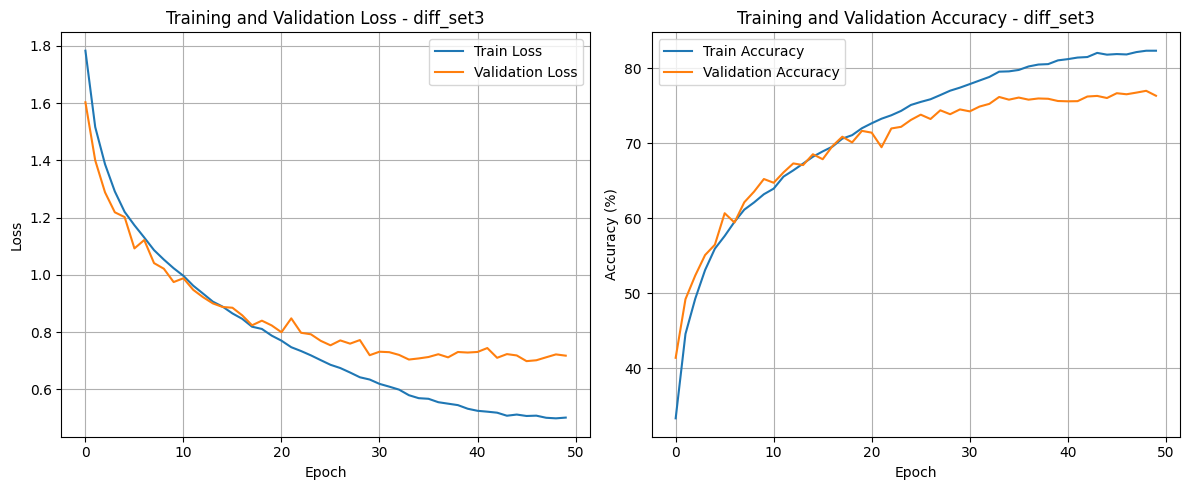


--- Running configuration diff_set4 ---
diff_set4: 9.25M parameters
Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.27it/s, loss=1.53, acc=43.2]


Epoch 1/50:
Train Loss: 1.7724 | Train Acc: 33.86%
Val Loss: 1.5308 | Val Acc: 43.20%
Validation accuracy improved from 0.00% to 43.20%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.28it/s, loss=1.37, acc=50]


Epoch 2/50:
Train Loss: 1.4598 | Train Acc: 46.64%
Val Loss: 1.3706 | Val Acc: 50.00%
Validation accuracy improved from 43.20% to 50.00%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.20it/s, loss=1.28, acc=54]


Epoch 3/50:
Train Loss: 1.3181 | Train Acc: 52.17%
Val Loss: 1.2797 | Val Acc: 54.04%
Validation accuracy improved from 50.00% to 54.04%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.23it/s, loss=1.15, acc=58.2]


Epoch 4/50:
Train Loss: 1.2257 | Train Acc: 55.28%
Val Loss: 1.1468 | Val Acc: 58.20%
Validation accuracy improved from 54.04% to 58.20%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.97it/s, loss=1.11, acc=59.7]


Epoch 5/50:
Train Loss: 1.1566 | Train Acc: 58.04%
Val Loss: 1.1061 | Val Acc: 59.66%
Validation accuracy improved from 58.20% to 59.66%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.23it/s, loss=1.05, acc=61.5]


Epoch 6/50:
Train Loss: 1.0991 | Train Acc: 60.25%
Val Loss: 1.0501 | Val Acc: 61.48%
Validation accuracy improved from 59.66% to 61.48%, saving model...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.35it/s, loss=1.04, acc=61.9]


Epoch 7/50:
Train Loss: 1.0543 | Train Acc: 62.04%
Val Loss: 1.0402 | Val Acc: 61.86%
Validation accuracy improved from 61.48% to 61.86%, saving model...


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.19it/s, loss=0.99, acc=63.9]


Epoch 8/50:
Train Loss: 1.0079 | Train Acc: 63.80%
Val Loss: 0.9898 | Val Acc: 63.92%
Validation accuracy improved from 61.86% to 63.92%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.06it/s, loss=0.952, acc=65.4]


Epoch 9/50:
Train Loss: 0.9692 | Train Acc: 65.11%
Val Loss: 0.9518 | Val Acc: 65.36%
Validation accuracy improved from 63.92% to 65.36%, saving model...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.24it/s, loss=0.887, acc=68.3]


Epoch 10/50:
Train Loss: 0.9222 | Train Acc: 66.73%
Val Loss: 0.8875 | Val Acc: 68.30%
Validation accuracy improved from 65.36% to 68.30%, saving model...


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.03it/s, loss=0.914, acc=67]


Epoch 11/50:
Train Loss: 0.8978 | Train Acc: 67.69%
Val Loss: 0.9143 | Val Acc: 67.04%


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.82it/s, loss=0.928, acc=67.7]


Epoch 12/50:
Train Loss: 0.8693 | Train Acc: 68.77%
Val Loss: 0.9278 | Val Acc: 67.66%


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.80it/s, loss=0.84, acc=70]


Epoch 13/50:
Train Loss: 0.8293 | Train Acc: 70.47%
Val Loss: 0.8402 | Val Acc: 70.00%
Validation accuracy improved from 68.30% to 70.00%, saving model...


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.89it/s, loss=0.819, acc=70.9]


Epoch 14/50:
Train Loss: 0.8090 | Train Acc: 71.07%
Val Loss: 0.8193 | Val Acc: 70.92%
Validation accuracy improved from 70.00% to 70.92%, saving model...


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.17it/s, loss=0.833, acc=70.7]


Epoch 15/50:
Train Loss: 0.7763 | Train Acc: 72.29%
Val Loss: 0.8327 | Val Acc: 70.66%


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.15it/s, loss=0.791, acc=72.6]


Epoch 16/50:
Train Loss: 0.7519 | Train Acc: 72.94%
Val Loss: 0.7914 | Val Acc: 72.60%
Validation accuracy improved from 70.92% to 72.60%, saving model...


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.21it/s, loss=0.787, acc=71.9]


Epoch 17/50:
Train Loss: 0.7187 | Train Acc: 74.19%
Val Loss: 0.7869 | Val Acc: 71.92%


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.15it/s, loss=0.77, acc=73]


Epoch 18/50:
Train Loss: 0.6970 | Train Acc: 74.94%
Val Loss: 0.7704 | Val Acc: 72.98%
Validation accuracy improved from 72.60% to 72.98%, saving model...


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.28it/s, loss=0.767, acc=73.4]


Epoch 19/50:
Train Loss: 0.6703 | Train Acc: 76.14%
Val Loss: 0.7671 | Val Acc: 73.42%
Validation accuracy improved from 72.98% to 73.42%, saving model...


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.18it/s, loss=0.731, acc=73.7]


Epoch 20/50:
Train Loss: 0.6432 | Train Acc: 76.98%
Val Loss: 0.7314 | Val Acc: 73.74%
Validation accuracy improved from 73.42% to 73.74%, saving model...


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.21it/s, loss=0.755, acc=73.6]


Epoch 21/50:
Train Loss: 0.6223 | Train Acc: 77.73%
Val Loss: 0.7548 | Val Acc: 73.60%


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.19it/s, loss=0.708, acc=75.2]


Epoch 22/50:
Train Loss: 0.6000 | Train Acc: 78.86%
Val Loss: 0.7082 | Val Acc: 75.24%
Validation accuracy improved from 73.74% to 75.24%, saving model...


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.13it/s, loss=0.737, acc=74.8]


Epoch 23/50:
Train Loss: 0.5667 | Train Acc: 79.82%
Val Loss: 0.7367 | Val Acc: 74.80%


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.14it/s, loss=0.713, acc=75.2]


Epoch 24/50:
Train Loss: 0.5523 | Train Acc: 80.19%
Val Loss: 0.7133 | Val Acc: 75.22%


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.08it/s, loss=0.729, acc=76]


Epoch 25/50:
Train Loss: 0.5247 | Train Acc: 81.17%
Val Loss: 0.7287 | Val Acc: 75.98%
Validation accuracy improved from 75.24% to 75.98%, saving model...


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.20it/s, loss=0.74, acc=75.1]


Epoch 26/50:
Train Loss: 0.5032 | Train Acc: 81.92%
Val Loss: 0.7398 | Val Acc: 75.08%


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.09it/s, loss=0.738, acc=75.6]


Epoch 27/50:
Train Loss: 0.4834 | Train Acc: 82.58%
Val Loss: 0.7377 | Val Acc: 75.56%


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.05it/s, loss=0.742, acc=75.6]


Epoch 28/50:
Train Loss: 0.4629 | Train Acc: 83.61%
Val Loss: 0.7422 | Val Acc: 75.56%


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.23it/s, loss=0.735, acc=75.9]


Epoch 29/50:
Train Loss: 0.4349 | Train Acc: 84.46%
Val Loss: 0.7348 | Val Acc: 75.86%


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.14it/s, loss=0.727, acc=76.7]


Epoch 30/50:
Train Loss: 0.4183 | Train Acc: 85.00%
Val Loss: 0.7270 | Val Acc: 76.70%
Validation accuracy improved from 75.98% to 76.70%, saving model...


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.10it/s, loss=0.703, acc=77.5]


Epoch 31/50:
Train Loss: 0.3948 | Train Acc: 85.94%
Val Loss: 0.7033 | Val Acc: 77.46%
Validation accuracy improved from 76.70% to 77.46%, saving model...


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.06it/s, loss=0.736, acc=76.2]


Epoch 32/50:
Train Loss: 0.3717 | Train Acc: 86.50%
Val Loss: 0.7358 | Val Acc: 76.24%


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.23it/s, loss=0.761, acc=76.9]


Epoch 33/50:
Train Loss: 0.3508 | Train Acc: 87.41%
Val Loss: 0.7609 | Val Acc: 76.86%


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.21it/s, loss=0.785, acc=76.8]


Epoch 34/50:
Train Loss: 0.3332 | Train Acc: 87.97%
Val Loss: 0.7846 | Val Acc: 76.80%


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.95it/s, loss=0.708, acc=78.4]


Epoch 35/50:
Train Loss: 0.3206 | Train Acc: 88.49%
Val Loss: 0.7081 | Val Acc: 78.38%
Validation accuracy improved from 77.46% to 78.38%, saving model...


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.27it/s, loss=0.751, acc=77.4]


Epoch 36/50:
Train Loss: 0.3021 | Train Acc: 89.09%
Val Loss: 0.7510 | Val Acc: 77.38%


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.22it/s, loss=0.731, acc=78.6]


Epoch 37/50:
Train Loss: 0.2874 | Train Acc: 89.60%
Val Loss: 0.7310 | Val Acc: 78.56%
Validation accuracy improved from 78.38% to 78.56%, saving model...


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.09it/s, loss=0.753, acc=78]


Epoch 38/50:
Train Loss: 0.2699 | Train Acc: 90.41%
Val Loss: 0.7532 | Val Acc: 78.02%


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.17it/s, loss=0.766, acc=77.7]


Epoch 39/50:
Train Loss: 0.2593 | Train Acc: 90.72%
Val Loss: 0.7661 | Val Acc: 77.74%


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.83it/s, loss=0.783, acc=78.1]


Epoch 40/50:
Train Loss: 0.2453 | Train Acc: 91.22%
Val Loss: 0.7827 | Val Acc: 78.12%


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.98it/s, loss=0.802, acc=77.8]


Epoch 41/50:
Train Loss: 0.2345 | Train Acc: 91.60%
Val Loss: 0.8019 | Val Acc: 77.82%


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.21it/s, loss=0.785, acc=78.1]


Epoch 42/50:
Train Loss: 0.2251 | Train Acc: 92.05%
Val Loss: 0.7854 | Val Acc: 78.08%


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.14it/s, loss=0.816, acc=78]


Epoch 43/50:
Train Loss: 0.2177 | Train Acc: 92.19%
Val Loss: 0.8163 | Val Acc: 77.98%


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.37it/s, loss=0.804, acc=78.3]


Epoch 44/50:
Train Loss: 0.2076 | Train Acc: 92.68%
Val Loss: 0.8039 | Val Acc: 78.28%


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.04it/s, loss=0.803, acc=77.6]


Epoch 45/50:
Train Loss: 0.2046 | Train Acc: 92.62%
Val Loss: 0.8031 | Val Acc: 77.58%


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.30it/s, loss=0.83, acc=78]


Epoch 46/50:
Train Loss: 0.2041 | Train Acc: 92.78%
Val Loss: 0.8298 | Val Acc: 78.04%


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.28it/s, loss=0.836, acc=78.2]


Epoch 47/50:
Train Loss: 0.1970 | Train Acc: 92.96%
Val Loss: 0.8365 | Val Acc: 78.24%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.35it/s, loss=0.814, acc=78.1]


Epoch 48/50:
Train Loss: 0.1928 | Train Acc: 93.21%
Val Loss: 0.8143 | Val Acc: 78.08%


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.30it/s, loss=0.859, acc=77.8]


Epoch 49/50:
Train Loss: 0.1943 | Train Acc: 93.04%
Val Loss: 0.8593 | Val Acc: 77.84%


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.30it/s, loss=0.798, acc=78.1]


Epoch 50/50:
Train Loss: 0.1893 | Train Acc: 93.29%
Val Loss: 0.7981 | Val Acc: 78.14%
Best validation accuracy: 78.56%
Loading best model for evaluation...


Evaluating on test set: 100%|██████████| 79/79 [00:04<00:00, 17.01it/s]


Test accuracy: 79.45%
Final test accuracy: 79.45%
Plotting metrics...


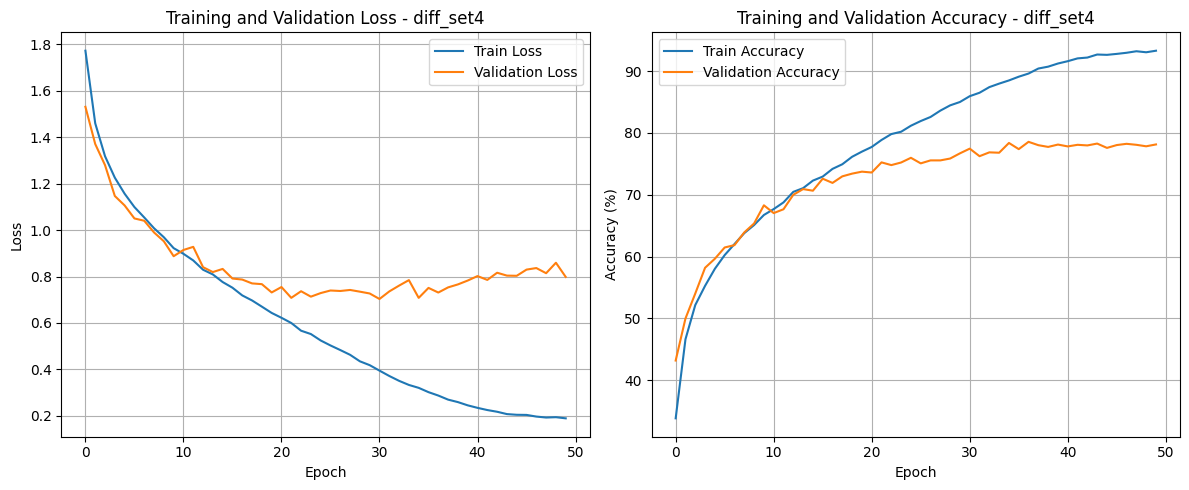


--- Running configuration diff_set5 ---
diff_set5: 2.92M parameters
Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.57it/s, loss=1.59, acc=42.4]


Epoch 1/50:
Train Loss: 1.7714 | Train Acc: 34.03%
Val Loss: 1.5855 | Val Acc: 42.40%
Validation accuracy improved from 0.00% to 42.40%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.40it/s, loss=1.39, acc=49]


Epoch 2/50:
Train Loss: 1.5219 | Train Acc: 43.79%
Val Loss: 1.3875 | Val Acc: 48.96%
Validation accuracy improved from 42.40% to 48.96%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.58it/s, loss=1.29, acc=53.7]


Epoch 3/50:
Train Loss: 1.3865 | Train Acc: 49.44%
Val Loss: 1.2903 | Val Acc: 53.74%
Validation accuracy improved from 48.96% to 53.74%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.55it/s, loss=1.22, acc=55]


Epoch 4/50:
Train Loss: 1.2892 | Train Acc: 53.20%
Val Loss: 1.2221 | Val Acc: 55.02%
Validation accuracy improved from 53.74% to 55.02%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.23it/s, loss=1.18, acc=56.4]


Epoch 5/50:
Train Loss: 1.2247 | Train Acc: 55.58%
Val Loss: 1.1792 | Val Acc: 56.38%
Validation accuracy improved from 55.02% to 56.38%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.25it/s, loss=1.13, acc=59.7]


Epoch 6/50:
Train Loss: 1.1703 | Train Acc: 57.41%
Val Loss: 1.1302 | Val Acc: 59.68%
Validation accuracy improved from 56.38% to 59.68%, saving model...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.36it/s, loss=1.09, acc=60.2]


Epoch 7/50:
Train Loss: 1.1349 | Train Acc: 59.01%
Val Loss: 1.0907 | Val Acc: 60.18%
Validation accuracy improved from 59.68% to 60.18%, saving model...


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.09it/s, loss=1.03, acc=63.2]


Epoch 8/50:
Train Loss: 1.0873 | Train Acc: 60.72%
Val Loss: 1.0290 | Val Acc: 63.16%
Validation accuracy improved from 60.18% to 63.16%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.11it/s, loss=1.01, acc=62.8]


Epoch 9/50:
Train Loss: 1.0551 | Train Acc: 62.04%
Val Loss: 1.0109 | Val Acc: 62.78%


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.85it/s, loss=0.984, acc=64.2]


Epoch 10/50:
Train Loss: 1.0178 | Train Acc: 63.21%
Val Loss: 0.9837 | Val Acc: 64.20%
Validation accuracy improved from 63.16% to 64.20%, saving model...


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.26it/s, loss=0.946, acc=65.8]


Epoch 11/50:
Train Loss: 0.9812 | Train Acc: 64.78%
Val Loss: 0.9460 | Val Acc: 65.80%
Validation accuracy improved from 64.20% to 65.80%, saving model...


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.16it/s, loss=0.979, acc=65]


Epoch 12/50:
Train Loss: 0.9607 | Train Acc: 65.31%
Val Loss: 0.9790 | Val Acc: 64.96%


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.58it/s, loss=0.918, acc=66.2]


Epoch 13/50:
Train Loss: 0.9281 | Train Acc: 66.67%
Val Loss: 0.9184 | Val Acc: 66.22%
Validation accuracy improved from 65.80% to 66.22%, saving model...


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.14it/s, loss=0.897, acc=68.1]


Epoch 14/50:
Train Loss: 0.9005 | Train Acc: 67.82%
Val Loss: 0.8973 | Val Acc: 68.08%
Validation accuracy improved from 66.22% to 68.08%, saving model...


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.38it/s, loss=0.87, acc=68.8]


Epoch 15/50:
Train Loss: 0.8695 | Train Acc: 68.68%
Val Loss: 0.8703 | Val Acc: 68.80%
Validation accuracy improved from 68.08% to 68.80%, saving model...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.16it/s, loss=0.829, acc=70.4]


Epoch 16/50:
Train Loss: 0.8502 | Train Acc: 69.52%
Val Loss: 0.8292 | Val Acc: 70.36%
Validation accuracy improved from 68.80% to 70.36%, saving model...


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.47it/s, loss=0.863, acc=68.7]


Epoch 17/50:
Train Loss: 0.8195 | Train Acc: 70.68%
Val Loss: 0.8629 | Val Acc: 68.66%


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.80it/s, loss=0.819, acc=70.1]


Epoch 18/50:
Train Loss: 0.8078 | Train Acc: 71.19%
Val Loss: 0.8192 | Val Acc: 70.08%


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.66it/s, loss=0.814, acc=71.4]


Epoch 19/50:
Train Loss: 0.7801 | Train Acc: 72.37%
Val Loss: 0.8140 | Val Acc: 71.38%
Validation accuracy improved from 70.36% to 71.38%, saving model...


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.12it/s, loss=0.792, acc=72.5]


Epoch 20/50:
Train Loss: 0.7573 | Train Acc: 72.96%
Val Loss: 0.7917 | Val Acc: 72.54%
Validation accuracy improved from 71.38% to 72.54%, saving model...


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.73it/s, loss=0.805, acc=72]


Epoch 21/50:
Train Loss: 0.7406 | Train Acc: 73.56%
Val Loss: 0.8050 | Val Acc: 72.00%


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.46it/s, loss=0.797, acc=72.2]


Epoch 22/50:
Train Loss: 0.7141 | Train Acc: 74.56%
Val Loss: 0.7967 | Val Acc: 72.22%


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.05it/s, loss=0.772, acc=73.1]


Epoch 23/50:
Train Loss: 0.7042 | Train Acc: 74.83%
Val Loss: 0.7724 | Val Acc: 73.06%
Validation accuracy improved from 72.54% to 73.06%, saving model...


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.20it/s, loss=0.75, acc=73]


Epoch 24/50:
Train Loss: 0.6749 | Train Acc: 75.88%
Val Loss: 0.7504 | Val Acc: 73.00%


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.77it/s, loss=0.754, acc=74]


Epoch 25/50:
Train Loss: 0.6630 | Train Acc: 76.20%
Val Loss: 0.7541 | Val Acc: 73.98%
Validation accuracy improved from 73.06% to 73.98%, saving model...


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.30it/s, loss=0.763, acc=74.1]


Epoch 26/50:
Train Loss: 0.6463 | Train Acc: 77.08%
Val Loss: 0.7628 | Val Acc: 74.10%
Validation accuracy improved from 73.98% to 74.10%, saving model...


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.90it/s, loss=0.761, acc=74]


Epoch 27/50:
Train Loss: 0.6311 | Train Acc: 77.53%
Val Loss: 0.7606 | Val Acc: 73.96%


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.69it/s, loss=0.712, acc=75.8]


Epoch 28/50:
Train Loss: 0.6136 | Train Acc: 78.06%
Val Loss: 0.7120 | Val Acc: 75.76%
Validation accuracy improved from 74.10% to 75.76%, saving model...


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.34it/s, loss=0.748, acc=74.5]


Epoch 29/50:
Train Loss: 0.5937 | Train Acc: 78.84%
Val Loss: 0.7476 | Val Acc: 74.54%


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.91it/s, loss=0.726, acc=75]


Epoch 30/50:
Train Loss: 0.5771 | Train Acc: 79.58%
Val Loss: 0.7261 | Val Acc: 74.96%


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.52it/s, loss=0.745, acc=75.3]


Epoch 31/50:
Train Loss: 0.5725 | Train Acc: 79.41%
Val Loss: 0.7451 | Val Acc: 75.26%


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 24.61it/s, loss=0.716, acc=75.9]


Epoch 32/50:
Train Loss: 0.5498 | Train Acc: 80.22%
Val Loss: 0.7165 | Val Acc: 75.90%
Validation accuracy improved from 75.76% to 75.90%, saving model...


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.76it/s, loss=0.734, acc=75.5]


Epoch 33/50:
Train Loss: 0.5323 | Train Acc: 80.91%
Val Loss: 0.7341 | Val Acc: 75.46%


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.22it/s, loss=0.709, acc=76.6]


Epoch 34/50:
Train Loss: 0.5235 | Train Acc: 81.20%
Val Loss: 0.7090 | Val Acc: 76.64%
Validation accuracy improved from 75.90% to 76.64%, saving model...


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.32it/s, loss=0.724, acc=76.5]


Epoch 35/50:
Train Loss: 0.5165 | Train Acc: 81.67%
Val Loss: 0.7244 | Val Acc: 76.48%


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.76it/s, loss=0.686, acc=77.3]


Epoch 36/50:
Train Loss: 0.5020 | Train Acc: 82.36%
Val Loss: 0.6863 | Val Acc: 77.32%
Validation accuracy improved from 76.64% to 77.32%, saving model...


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.73it/s, loss=0.689, acc=76.9]


Epoch 37/50:
Train Loss: 0.4931 | Train Acc: 82.38%
Val Loss: 0.6891 | Val Acc: 76.88%


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.23it/s, loss=0.704, acc=76.4]


Epoch 38/50:
Train Loss: 0.4830 | Train Acc: 82.58%
Val Loss: 0.7037 | Val Acc: 76.36%


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.56it/s, loss=0.706, acc=76.9]


Epoch 39/50:
Train Loss: 0.4737 | Train Acc: 83.00%
Val Loss: 0.7060 | Val Acc: 76.92%


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.90it/s, loss=0.703, acc=77.5]


Epoch 40/50:
Train Loss: 0.4612 | Train Acc: 83.60%
Val Loss: 0.7033 | Val Acc: 77.46%
Validation accuracy improved from 77.32% to 77.46%, saving model...


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.03it/s, loss=0.718, acc=77]


Epoch 41/50:
Train Loss: 0.4541 | Train Acc: 83.77%
Val Loss: 0.7181 | Val Acc: 76.96%


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.65it/s, loss=0.696, acc=77.1]


Epoch 42/50:
Train Loss: 0.4480 | Train Acc: 84.04%
Val Loss: 0.6963 | Val Acc: 77.14%


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.37it/s, loss=0.714, acc=77.6]


Epoch 43/50:
Train Loss: 0.4426 | Train Acc: 84.24%
Val Loss: 0.7144 | Val Acc: 77.58%
Validation accuracy improved from 77.46% to 77.58%, saving model...


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.29it/s, loss=0.716, acc=77.1]


Epoch 44/50:
Train Loss: 0.4363 | Train Acc: 84.33%
Val Loss: 0.7163 | Val Acc: 77.10%


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.83it/s, loss=0.696, acc=77.4]


Epoch 45/50:
Train Loss: 0.4306 | Train Acc: 84.65%
Val Loss: 0.6956 | Val Acc: 77.38%


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.14it/s, loss=0.704, acc=77.9]


Epoch 46/50:
Train Loss: 0.4300 | Train Acc: 84.72%
Val Loss: 0.7041 | Val Acc: 77.94%
Validation accuracy improved from 77.58% to 77.94%, saving model...


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.79it/s, loss=0.696, acc=77.4]


Epoch 47/50:
Train Loss: 0.4267 | Train Acc: 84.76%
Val Loss: 0.6961 | Val Acc: 77.40%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.00it/s, loss=0.71, acc=77.5]


Epoch 48/50:
Train Loss: 0.4245 | Train Acc: 84.82%
Val Loss: 0.7100 | Val Acc: 77.50%


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 31.14it/s, loss=0.711, acc=77.5]


Epoch 49/50:
Train Loss: 0.4260 | Train Acc: 84.81%
Val Loss: 0.7108 | Val Acc: 77.46%


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.73it/s, loss=0.712, acc=77.3]


Epoch 50/50:
Train Loss: 0.4274 | Train Acc: 84.87%
Val Loss: 0.7122 | Val Acc: 77.30%
Best validation accuracy: 77.94%
Loading best model for evaluation...


Evaluating on test set: 100%|██████████| 79/79 [00:02<00:00, 38.06it/s]


Test accuracy: 78.04%
Final test accuracy: 78.04%
Plotting metrics...


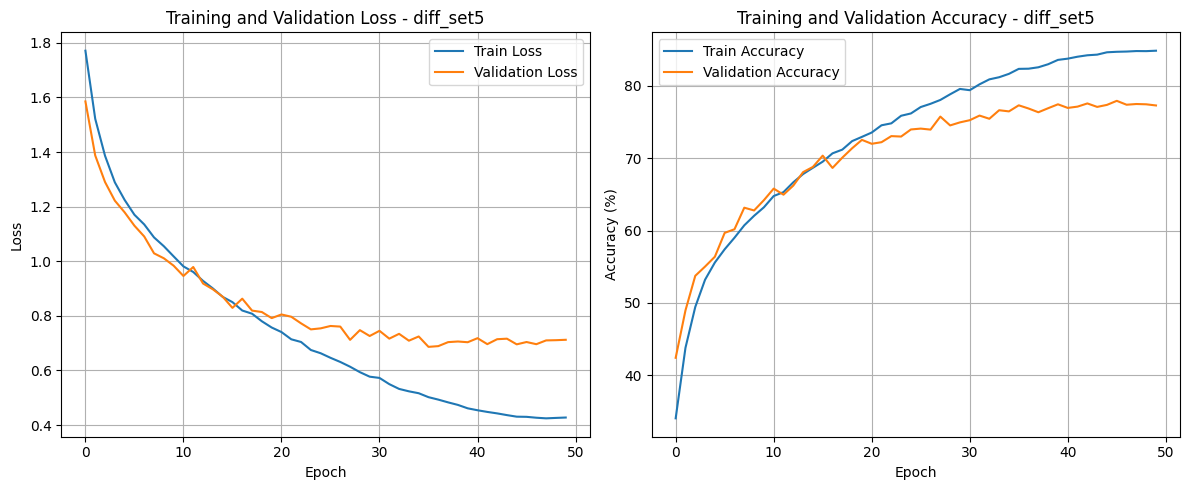


--- Running configuration diff_set6 ---
diff_set6: 3.58M parameters
Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.49it/s, loss=1.61, acc=41]


Epoch 1/50:
Train Loss: 1.7886 | Train Acc: 33.40%
Val Loss: 1.6115 | Val Acc: 40.96%
Validation accuracy improved from 0.00% to 40.96%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.99it/s, loss=1.47, acc=45.9]


Epoch 2/50:
Train Loss: 1.5350 | Train Acc: 43.78%
Val Loss: 1.4749 | Val Acc: 45.94%
Validation accuracy improved from 40.96% to 45.94%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.56it/s, loss=1.33, acc=52.8]


Epoch 3/50:
Train Loss: 1.3937 | Train Acc: 49.03%
Val Loss: 1.3273 | Val Acc: 52.84%
Validation accuracy improved from 45.94% to 52.84%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.05it/s, loss=1.22, acc=54.5]


Epoch 4/50:
Train Loss: 1.3039 | Train Acc: 52.42%
Val Loss: 1.2240 | Val Acc: 54.50%
Validation accuracy improved from 52.84% to 54.50%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.26it/s, loss=1.2, acc=56.2]


Epoch 5/50:
Train Loss: 1.2321 | Train Acc: 55.44%
Val Loss: 1.1971 | Val Acc: 56.20%
Validation accuracy improved from 54.50% to 56.20%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.07it/s, loss=1.09, acc=61.4]


Epoch 6/50:
Train Loss: 1.1641 | Train Acc: 57.79%
Val Loss: 1.0914 | Val Acc: 61.42%
Validation accuracy improved from 56.20% to 61.42%, saving model...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.96it/s, loss=1.08, acc=61.1]


Epoch 7/50:
Train Loss: 1.1170 | Train Acc: 59.91%
Val Loss: 1.0838 | Val Acc: 61.10%


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.47it/s, loss=1.02, acc=62.6]


Epoch 8/50:
Train Loss: 1.0750 | Train Acc: 61.18%
Val Loss: 1.0167 | Val Acc: 62.60%
Validation accuracy improved from 61.42% to 62.60%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.58it/s, loss=0.974, acc=64.3]


Epoch 9/50:
Train Loss: 1.0297 | Train Acc: 62.97%
Val Loss: 0.9741 | Val Acc: 64.34%
Validation accuracy improved from 62.60% to 64.34%, saving model...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.98it/s, loss=0.981, acc=64.2]


Epoch 10/50:
Train Loss: 0.9907 | Train Acc: 64.34%
Val Loss: 0.9809 | Val Acc: 64.16%


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.06it/s, loss=0.948, acc=65.2]


Epoch 11/50:
Train Loss: 0.9653 | Train Acc: 65.39%
Val Loss: 0.9477 | Val Acc: 65.18%
Validation accuracy improved from 64.34% to 65.18%, saving model...


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.67it/s, loss=0.889, acc=68.1]


Epoch 12/50:
Train Loss: 0.9187 | Train Acc: 67.06%
Val Loss: 0.8888 | Val Acc: 68.10%
Validation accuracy improved from 65.18% to 68.10%, saving model...


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 24.92it/s, loss=0.855, acc=68.7]


Epoch 13/50:
Train Loss: 0.8895 | Train Acc: 67.99%
Val Loss: 0.8546 | Val Acc: 68.70%
Validation accuracy improved from 68.10% to 68.70%, saving model...


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.48it/s, loss=0.9, acc=67.3]


Epoch 14/50:
Train Loss: 0.8606 | Train Acc: 69.17%
Val Loss: 0.8997 | Val Acc: 67.30%


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.14it/s, loss=0.844, acc=69.3]


Epoch 15/50:
Train Loss: 0.8364 | Train Acc: 70.00%
Val Loss: 0.8436 | Val Acc: 69.28%
Validation accuracy improved from 68.70% to 69.28%, saving model...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.67it/s, loss=0.831, acc=70.2]


Epoch 16/50:
Train Loss: 0.8135 | Train Acc: 71.14%
Val Loss: 0.8305 | Val Acc: 70.16%
Validation accuracy improved from 69.28% to 70.16%, saving model...


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 24.68it/s, loss=0.813, acc=70.9]


Epoch 17/50:
Train Loss: 0.7877 | Train Acc: 72.12%
Val Loss: 0.8130 | Val Acc: 70.92%
Validation accuracy improved from 70.16% to 70.92%, saving model...


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.69it/s, loss=0.782, acc=72.4]


Epoch 18/50:
Train Loss: 0.7669 | Train Acc: 72.52%
Val Loss: 0.7821 | Val Acc: 72.44%
Validation accuracy improved from 70.92% to 72.44%, saving model...


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.69it/s, loss=0.767, acc=72.3]


Epoch 19/50:
Train Loss: 0.7436 | Train Acc: 73.67%
Val Loss: 0.7667 | Val Acc: 72.32%


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 24.28it/s, loss=0.774, acc=72.9]


Epoch 20/50:
Train Loss: 0.7181 | Train Acc: 74.20%
Val Loss: 0.7738 | Val Acc: 72.90%
Validation accuracy improved from 72.44% to 72.90%, saving model...


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.04it/s, loss=0.75, acc=72.9]


Epoch 21/50:
Train Loss: 0.7035 | Train Acc: 75.00%
Val Loss: 0.7504 | Val Acc: 72.92%
Validation accuracy improved from 72.90% to 72.92%, saving model...


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.79it/s, loss=0.741, acc=73.7]


Epoch 22/50:
Train Loss: 0.6824 | Train Acc: 75.90%
Val Loss: 0.7410 | Val Acc: 73.68%
Validation accuracy improved from 72.92% to 73.68%, saving model...


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.57it/s, loss=0.723, acc=74.5]


Epoch 23/50:
Train Loss: 0.6627 | Train Acc: 76.43%
Val Loss: 0.7234 | Val Acc: 74.46%
Validation accuracy improved from 73.68% to 74.46%, saving model...


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.98it/s, loss=0.765, acc=74]


Epoch 24/50:
Train Loss: 0.6410 | Train Acc: 77.21%
Val Loss: 0.7645 | Val Acc: 74.04%


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.43it/s, loss=0.703, acc=76.1]


Epoch 25/50:
Train Loss: 0.6219 | Train Acc: 77.71%
Val Loss: 0.7034 | Val Acc: 76.10%
Validation accuracy improved from 74.46% to 76.10%, saving model...


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.68it/s, loss=0.711, acc=75.6]


Epoch 26/50:
Train Loss: 0.6106 | Train Acc: 78.22%
Val Loss: 0.7107 | Val Acc: 75.62%


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.27it/s, loss=0.702, acc=76.5]


Epoch 27/50:
Train Loss: 0.5884 | Train Acc: 78.87%
Val Loss: 0.7023 | Val Acc: 76.46%
Validation accuracy improved from 76.10% to 76.46%, saving model...


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.14it/s, loss=0.693, acc=76.3]


Epoch 28/50:
Train Loss: 0.5686 | Train Acc: 79.84%
Val Loss: 0.6933 | Val Acc: 76.30%


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 24.90it/s, loss=0.713, acc=75.5]


Epoch 29/50:
Train Loss: 0.5555 | Train Acc: 80.08%
Val Loss: 0.7128 | Val Acc: 75.46%


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.27it/s, loss=0.712, acc=75.6]


Epoch 30/50:
Train Loss: 0.5408 | Train Acc: 80.65%
Val Loss: 0.7116 | Val Acc: 75.62%


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.02it/s, loss=0.703, acc=76.6]


Epoch 31/50:
Train Loss: 0.5217 | Train Acc: 81.40%
Val Loss: 0.7032 | Val Acc: 76.58%
Validation accuracy improved from 76.46% to 76.58%, saving model...


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.54it/s, loss=0.701, acc=77]


Epoch 32/50:
Train Loss: 0.5089 | Train Acc: 81.95%
Val Loss: 0.7008 | Val Acc: 76.96%
Validation accuracy improved from 76.58% to 76.96%, saving model...


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.00it/s, loss=0.68, acc=76.6]


Epoch 33/50:
Train Loss: 0.4899 | Train Acc: 82.43%
Val Loss: 0.6805 | Val Acc: 76.58%


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.60it/s, loss=0.697, acc=77.6]


Epoch 34/50:
Train Loss: 0.4790 | Train Acc: 82.88%
Val Loss: 0.6972 | Val Acc: 77.62%
Validation accuracy improved from 76.96% to 77.62%, saving model...


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.11it/s, loss=0.693, acc=76.9]


Epoch 35/50:
Train Loss: 0.4672 | Train Acc: 83.35%
Val Loss: 0.6929 | Val Acc: 76.92%


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 24.01it/s, loss=0.725, acc=77.1]


Epoch 36/50:
Train Loss: 0.4552 | Train Acc: 83.82%
Val Loss: 0.7248 | Val Acc: 77.10%


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.17it/s, loss=0.713, acc=77.1]


Epoch 37/50:
Train Loss: 0.4423 | Train Acc: 84.31%
Val Loss: 0.7129 | Val Acc: 77.06%


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.09it/s, loss=0.714, acc=77.1]


Epoch 38/50:
Train Loss: 0.4280 | Train Acc: 84.70%
Val Loss: 0.7144 | Val Acc: 77.06%


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.77it/s, loss=0.686, acc=78.1]


Epoch 39/50:
Train Loss: 0.4207 | Train Acc: 85.02%
Val Loss: 0.6864 | Val Acc: 78.08%
Validation accuracy improved from 77.62% to 78.08%, saving model...


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.50it/s, loss=0.7, acc=77.4]


Epoch 40/50:
Train Loss: 0.4078 | Train Acc: 85.54%
Val Loss: 0.6995 | Val Acc: 77.36%


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 24.52it/s, loss=0.702, acc=77.1]


Epoch 41/50:
Train Loss: 0.4055 | Train Acc: 85.58%
Val Loss: 0.7018 | Val Acc: 77.10%


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.57it/s, loss=0.717, acc=77.4]


Epoch 42/50:
Train Loss: 0.3949 | Train Acc: 85.77%
Val Loss: 0.7174 | Val Acc: 77.38%


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.94it/s, loss=0.705, acc=78.2]


Epoch 43/50:
Train Loss: 0.3910 | Train Acc: 86.10%
Val Loss: 0.7047 | Val Acc: 78.20%
Validation accuracy improved from 78.08% to 78.20%, saving model...


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.05it/s, loss=0.722, acc=78.1]


Epoch 44/50:
Train Loss: 0.3872 | Train Acc: 86.19%
Val Loss: 0.7218 | Val Acc: 78.12%


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.23it/s, loss=0.69, acc=78.3]


Epoch 45/50:
Train Loss: 0.3823 | Train Acc: 86.14%
Val Loss: 0.6895 | Val Acc: 78.26%
Validation accuracy improved from 78.20% to 78.26%, saving model...


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.20it/s, loss=0.708, acc=77.6]


Epoch 46/50:
Train Loss: 0.3785 | Train Acc: 86.51%
Val Loss: 0.7078 | Val Acc: 77.62%


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.73it/s, loss=0.694, acc=77.9]


Epoch 47/50:
Train Loss: 0.3761 | Train Acc: 86.65%
Val Loss: 0.6938 | Val Acc: 77.94%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.37it/s, loss=0.692, acc=78.1]


Epoch 48/50:
Train Loss: 0.3666 | Train Acc: 86.98%
Val Loss: 0.6923 | Val Acc: 78.12%


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.32it/s, loss=0.682, acc=78.3]


Epoch 49/50:
Train Loss: 0.3704 | Train Acc: 86.61%
Val Loss: 0.6825 | Val Acc: 78.28%
Validation accuracy improved from 78.26% to 78.28%, saving model...


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.39it/s, loss=0.69, acc=78.3]


Epoch 50/50:
Train Loss: 0.3720 | Train Acc: 86.58%
Val Loss: 0.6905 | Val Acc: 78.34%
Validation accuracy improved from 78.28% to 78.34%, saving model...
Best validation accuracy: 78.34%
Loading best model for evaluation...


Evaluating on test set: 100%|██████████| 79/79 [00:02<00:00, 30.24it/s]


Test accuracy: 78.83%
Final test accuracy: 78.83%
Plotting metrics...


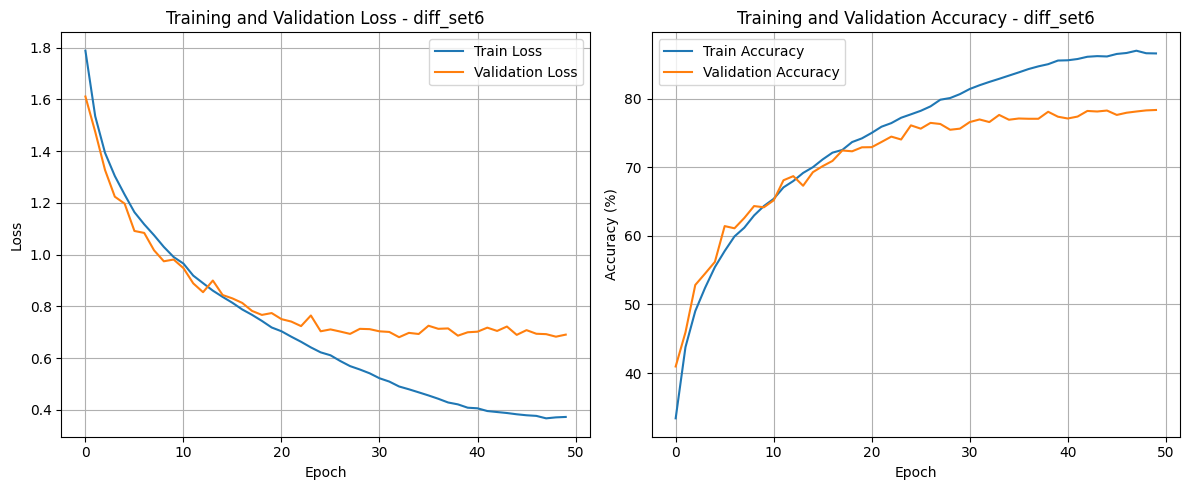


--- Running configuration diff_set7 ---
diff_set7: 4.18M parameters
Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.53it/s, loss=1.7, acc=36.7]


Epoch 1/50:
Train Loss: 1.8579 | Train Acc: 30.05%
Val Loss: 1.7009 | Val Acc: 36.70%
Validation accuracy improved from 0.00% to 36.70%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.11it/s, loss=1.56, acc=43.5]


Epoch 2/50:
Train Loss: 1.6194 | Train Acc: 39.80%
Val Loss: 1.5641 | Val Acc: 43.54%
Validation accuracy improved from 36.70% to 43.54%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.69it/s, loss=1.36, acc=50]


Epoch 3/50:
Train Loss: 1.4748 | Train Acc: 45.99%
Val Loss: 1.3629 | Val Acc: 49.96%
Validation accuracy improved from 43.54% to 49.96%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.05it/s, loss=1.28, acc=53.5]


Epoch 4/50:
Train Loss: 1.3740 | Train Acc: 49.91%
Val Loss: 1.2768 | Val Acc: 53.50%
Validation accuracy improved from 49.96% to 53.50%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.68it/s, loss=1.29, acc=53.8]


Epoch 5/50:
Train Loss: 1.3120 | Train Acc: 52.13%
Val Loss: 1.2910 | Val Acc: 53.80%
Validation accuracy improved from 53.50% to 53.80%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.42it/s, loss=1.23, acc=56.1]


Epoch 6/50:
Train Loss: 1.2542 | Train Acc: 54.39%
Val Loss: 1.2256 | Val Acc: 56.06%
Validation accuracy improved from 53.80% to 56.06%, saving model...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.08it/s, loss=1.21, acc=56.3]


Epoch 7/50:
Train Loss: 1.2165 | Train Acc: 55.77%
Val Loss: 1.2136 | Val Acc: 56.26%
Validation accuracy improved from 56.06% to 56.26%, saving model...


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.50it/s, loss=1.19, acc=56.6]


Epoch 8/50:
Train Loss: 1.1669 | Train Acc: 57.79%
Val Loss: 1.1893 | Val Acc: 56.58%
Validation accuracy improved from 56.26% to 56.58%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.39it/s, loss=1.09, acc=60.9]


Epoch 9/50:
Train Loss: 1.1458 | Train Acc: 58.76%
Val Loss: 1.0923 | Val Acc: 60.90%
Validation accuracy improved from 56.58% to 60.90%, saving model...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.45it/s, loss=1.1, acc=61.2]


Epoch 10/50:
Train Loss: 1.1166 | Train Acc: 59.68%
Val Loss: 1.0955 | Val Acc: 61.18%
Validation accuracy improved from 60.90% to 61.18%, saving model...


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.83it/s, loss=1.09, acc=61.9]


Epoch 11/50:
Train Loss: 1.0888 | Train Acc: 60.45%
Val Loss: 1.0884 | Val Acc: 61.92%
Validation accuracy improved from 61.18% to 61.92%, saving model...


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.57it/s, loss=1.03, acc=62.8]


Epoch 12/50:
Train Loss: 1.0671 | Train Acc: 61.35%
Val Loss: 1.0342 | Val Acc: 62.80%
Validation accuracy improved from 61.92% to 62.80%, saving model...


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.75it/s, loss=1, acc=64.1]


Epoch 13/50:
Train Loss: 1.0418 | Train Acc: 62.51%
Val Loss: 1.0021 | Val Acc: 64.10%
Validation accuracy improved from 62.80% to 64.10%, saving model...


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.26it/s, loss=0.988, acc=64.3]


Epoch 14/50:
Train Loss: 1.0314 | Train Acc: 62.96%
Val Loss: 0.9885 | Val Acc: 64.28%
Validation accuracy improved from 64.10% to 64.28%, saving model...


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.38it/s, loss=0.977, acc=65.6]


Epoch 15/50:
Train Loss: 1.0079 | Train Acc: 63.64%
Val Loss: 0.9773 | Val Acc: 65.58%
Validation accuracy improved from 64.28% to 65.58%, saving model...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.78it/s, loss=0.975, acc=65.8]


Epoch 16/50:
Train Loss: 0.9924 | Train Acc: 64.50%
Val Loss: 0.9754 | Val Acc: 65.80%
Validation accuracy improved from 65.58% to 65.80%, saving model...


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.62it/s, loss=0.995, acc=65.1]


Epoch 17/50:
Train Loss: 0.9723 | Train Acc: 64.90%
Val Loss: 0.9950 | Val Acc: 65.12%


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.50it/s, loss=1.05, acc=63.5]


Epoch 18/50:
Train Loss: 0.9543 | Train Acc: 65.62%
Val Loss: 1.0504 | Val Acc: 63.50%


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.63it/s, loss=0.951, acc=66.5]


Epoch 19/50:
Train Loss: 0.9440 | Train Acc: 66.12%
Val Loss: 0.9514 | Val Acc: 66.54%
Validation accuracy improved from 65.80% to 66.54%, saving model...


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.46it/s, loss=1.02, acc=65.4]


Epoch 20/50:
Train Loss: 0.9254 | Train Acc: 66.82%
Val Loss: 1.0203 | Val Acc: 65.42%


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.71it/s, loss=0.995, acc=66]


Epoch 21/50:
Train Loss: 0.9107 | Train Acc: 67.33%
Val Loss: 0.9945 | Val Acc: 66.02%


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.70it/s, loss=0.931, acc=66.8]


Epoch 22/50:
Train Loss: 0.8955 | Train Acc: 67.84%
Val Loss: 0.9314 | Val Acc: 66.78%
Validation accuracy improved from 66.54% to 66.78%, saving model...


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.94it/s, loss=0.901, acc=68.9]


Epoch 23/50:
Train Loss: 0.8826 | Train Acc: 68.50%
Val Loss: 0.9008 | Val Acc: 68.94%
Validation accuracy improved from 66.78% to 68.94%, saving model...


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.58it/s, loss=0.91, acc=68.6]


Epoch 24/50:
Train Loss: 0.8676 | Train Acc: 68.86%
Val Loss: 0.9102 | Val Acc: 68.56%


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.98it/s, loss=0.888, acc=69.6]


Epoch 25/50:
Train Loss: 0.8512 | Train Acc: 69.43%
Val Loss: 0.8877 | Val Acc: 69.62%
Validation accuracy improved from 68.94% to 69.62%, saving model...


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.50it/s, loss=0.91, acc=68.1]


Epoch 26/50:
Train Loss: 0.8407 | Train Acc: 69.64%
Val Loss: 0.9102 | Val Acc: 68.12%


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.36it/s, loss=0.878, acc=70.1]


Epoch 27/50:
Train Loss: 0.8291 | Train Acc: 70.07%
Val Loss: 0.8776 | Val Acc: 70.14%
Validation accuracy improved from 69.62% to 70.14%, saving model...


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.00it/s, loss=0.891, acc=68.1]


Epoch 28/50:
Train Loss: 0.8171 | Train Acc: 70.76%
Val Loss: 0.8914 | Val Acc: 68.10%


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.28it/s, loss=0.883, acc=70.2]


Epoch 29/50:
Train Loss: 0.8043 | Train Acc: 71.32%
Val Loss: 0.8832 | Val Acc: 70.22%
Validation accuracy improved from 70.14% to 70.22%, saving model...


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.04it/s, loss=0.902, acc=68.8]


Epoch 30/50:
Train Loss: 0.7948 | Train Acc: 71.48%
Val Loss: 0.9019 | Val Acc: 68.80%


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.59it/s, loss=0.859, acc=70]


Epoch 31/50:
Train Loss: 0.7848 | Train Acc: 71.83%
Val Loss: 0.8592 | Val Acc: 69.96%


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.94it/s, loss=0.893, acc=70]


Epoch 32/50:
Train Loss: 0.7707 | Train Acc: 72.19%
Val Loss: 0.8932 | Val Acc: 70.04%


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.23it/s, loss=0.873, acc=70.4]


Epoch 33/50:
Train Loss: 0.7625 | Train Acc: 72.56%
Val Loss: 0.8735 | Val Acc: 70.36%
Validation accuracy improved from 70.22% to 70.36%, saving model...


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.28it/s, loss=0.875, acc=70.5]


Epoch 34/50:
Train Loss: 0.7537 | Train Acc: 72.99%
Val Loss: 0.8749 | Val Acc: 70.52%
Validation accuracy improved from 70.36% to 70.52%, saving model...


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.00it/s, loss=0.86, acc=70.7]


Epoch 35/50:
Train Loss: 0.7398 | Train Acc: 73.38%
Val Loss: 0.8605 | Val Acc: 70.72%
Validation accuracy improved from 70.52% to 70.72%, saving model...


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.16it/s, loss=0.859, acc=71.2]


Epoch 36/50:
Train Loss: 0.7320 | Train Acc: 73.64%
Val Loss: 0.8590 | Val Acc: 71.18%
Validation accuracy improved from 70.72% to 71.18%, saving model...


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.78it/s, loss=0.89, acc=71.1]


Epoch 37/50:
Train Loss: 0.7198 | Train Acc: 74.12%
Val Loss: 0.8903 | Val Acc: 71.12%


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.55it/s, loss=0.9, acc=70.6]


Epoch 38/50:
Train Loss: 0.7117 | Train Acc: 74.30%
Val Loss: 0.9001 | Val Acc: 70.64%


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.67it/s, loss=0.885, acc=71.1]


Epoch 39/50:
Train Loss: 0.7106 | Train Acc: 74.52%
Val Loss: 0.8850 | Val Acc: 71.08%


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.01it/s, loss=0.897, acc=70.2]


Epoch 40/50:
Train Loss: 0.7055 | Train Acc: 74.76%
Val Loss: 0.8970 | Val Acc: 70.18%


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.70it/s, loss=0.887, acc=70.8]


Epoch 41/50:
Train Loss: 0.6934 | Train Acc: 75.01%
Val Loss: 0.8866 | Val Acc: 70.80%


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.31it/s, loss=0.86, acc=71.2]


Epoch 42/50:
Train Loss: 0.6904 | Train Acc: 75.13%
Val Loss: 0.8603 | Val Acc: 71.22%
Validation accuracy improved from 71.18% to 71.22%, saving model...


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.99it/s, loss=0.873, acc=71.2]


Epoch 43/50:
Train Loss: 0.6804 | Train Acc: 75.68%
Val Loss: 0.8726 | Val Acc: 71.22%


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.16it/s, loss=0.868, acc=71.3]


Epoch 44/50:
Train Loss: 0.6809 | Train Acc: 75.33%
Val Loss: 0.8676 | Val Acc: 71.30%
Validation accuracy improved from 71.22% to 71.30%, saving model...


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.78it/s, loss=0.889, acc=71.6]


Epoch 45/50:
Train Loss: 0.6744 | Train Acc: 75.79%
Val Loss: 0.8887 | Val Acc: 71.56%
Validation accuracy improved from 71.30% to 71.56%, saving model...


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.60it/s, loss=0.861, acc=71.3]


Epoch 46/50:
Train Loss: 0.6768 | Train Acc: 75.95%
Val Loss: 0.8606 | Val Acc: 71.30%


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.03it/s, loss=0.883, acc=71.6]


Epoch 47/50:
Train Loss: 0.6711 | Train Acc: 76.16%
Val Loss: 0.8832 | Val Acc: 71.56%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.44it/s, loss=0.9, acc=70.9]


Epoch 48/50:
Train Loss: 0.6700 | Train Acc: 76.20%
Val Loss: 0.8997 | Val Acc: 70.86%


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.48it/s, loss=0.88, acc=70.7]


Epoch 49/50:
Train Loss: 0.6695 | Train Acc: 75.95%
Val Loss: 0.8795 | Val Acc: 70.68%


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.07it/s, loss=0.866, acc=70.9]


Epoch 50/50:
Train Loss: 0.6700 | Train Acc: 75.85%
Val Loss: 0.8657 | Val Acc: 70.94%
Best validation accuracy: 71.56%
Loading best model for evaluation...


Evaluating on test set: 100%|██████████| 79/79 [00:03<00:00, 25.75it/s]


Test accuracy: 71.93%
Final test accuracy: 71.93%
Plotting metrics...


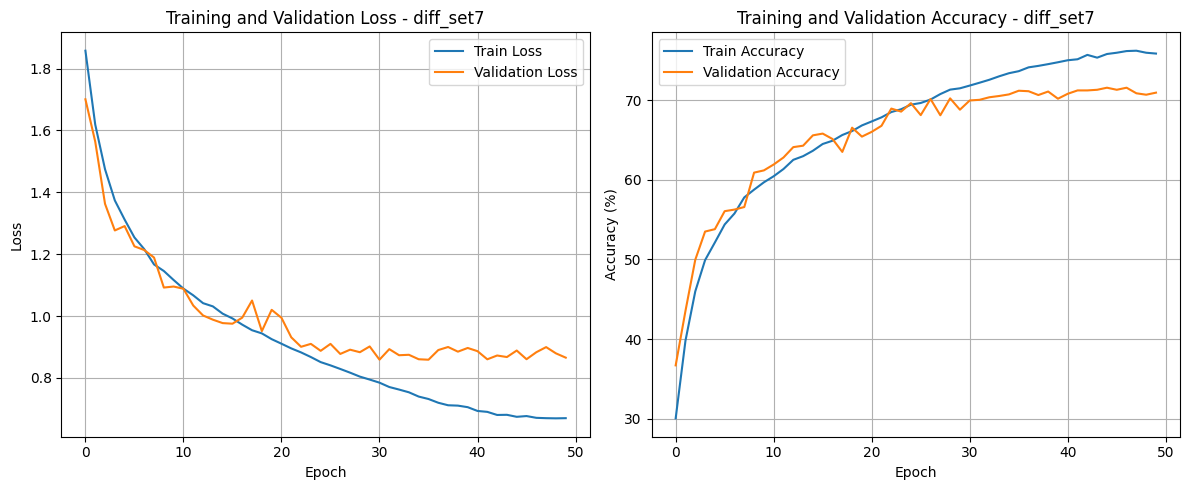


--- Running configuration diff_set8 ---
diff_set8: 4.18M parameters
Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.33it/s, loss=1.61, acc=42.3]


Epoch 1/50:
Train Loss: 1.7610 | Train Acc: 34.40%
Val Loss: 1.6062 | Val Acc: 42.30%
Validation accuracy improved from 0.00% to 42.30%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.61it/s, loss=1.41, acc=48.5]


Epoch 2/50:
Train Loss: 1.4848 | Train Acc: 45.60%
Val Loss: 1.4081 | Val Acc: 48.52%
Validation accuracy improved from 42.30% to 48.52%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.44it/s, loss=1.29, acc=53.9]


Epoch 3/50:
Train Loss: 1.3394 | Train Acc: 51.31%
Val Loss: 1.2876 | Val Acc: 53.94%
Validation accuracy improved from 48.52% to 53.94%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.39it/s, loss=1.17, acc=57.8]


Epoch 4/50:
Train Loss: 1.2553 | Train Acc: 54.54%
Val Loss: 1.1663 | Val Acc: 57.82%
Validation accuracy improved from 53.94% to 57.82%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.22it/s, loss=1.14, acc=58.8]


Epoch 5/50:
Train Loss: 1.1770 | Train Acc: 57.41%
Val Loss: 1.1406 | Val Acc: 58.82%
Validation accuracy improved from 57.82% to 58.82%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.15it/s, loss=1.09, acc=60.7]


Epoch 6/50:
Train Loss: 1.1177 | Train Acc: 59.66%
Val Loss: 1.0891 | Val Acc: 60.68%
Validation accuracy improved from 58.82% to 60.68%, saving model...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.04it/s, loss=1.02, acc=62.8]


Epoch 7/50:
Train Loss: 1.0727 | Train Acc: 61.34%
Val Loss: 1.0198 | Val Acc: 62.84%
Validation accuracy improved from 60.68% to 62.84%, saving model...


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.30it/s, loss=0.958, acc=65.2]


Epoch 8/50:
Train Loss: 1.0293 | Train Acc: 62.98%
Val Loss: 0.9582 | Val Acc: 65.16%
Validation accuracy improved from 62.84% to 65.16%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.09it/s, loss=0.975, acc=65.2]


Epoch 9/50:
Train Loss: 0.9827 | Train Acc: 64.71%
Val Loss: 0.9746 | Val Acc: 65.18%
Validation accuracy improved from 65.16% to 65.18%, saving model...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.98it/s, loss=0.945, acc=66.3]


Epoch 10/50:
Train Loss: 0.9460 | Train Acc: 66.14%
Val Loss: 0.9447 | Val Acc: 66.32%
Validation accuracy improved from 65.18% to 66.32%, saving model...


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.80it/s, loss=0.909, acc=66.5]


Epoch 11/50:
Train Loss: 0.9092 | Train Acc: 67.53%
Val Loss: 0.9092 | Val Acc: 66.54%
Validation accuracy improved from 66.32% to 66.54%, saving model...


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 25.75it/s, loss=0.857, acc=69.5]


Epoch 12/50:
Train Loss: 0.8834 | Train Acc: 68.33%
Val Loss: 0.8572 | Val Acc: 69.46%
Validation accuracy improved from 66.54% to 69.46%, saving model...


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.81it/s, loss=0.854, acc=69.5]


Epoch 13/50:
Train Loss: 0.8497 | Train Acc: 69.72%
Val Loss: 0.8541 | Val Acc: 69.48%
Validation accuracy improved from 69.46% to 69.48%, saving model...


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.59it/s, loss=0.836, acc=70.5]


Epoch 14/50:
Train Loss: 0.8224 | Train Acc: 70.75%
Val Loss: 0.8362 | Val Acc: 70.52%
Validation accuracy improved from 69.48% to 70.52%, saving model...


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.58it/s, loss=0.81, acc=71.3]


Epoch 15/50:
Train Loss: 0.7903 | Train Acc: 71.83%
Val Loss: 0.8100 | Val Acc: 71.28%
Validation accuracy improved from 70.52% to 71.28%, saving model...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.94it/s, loss=0.805, acc=72]


Epoch 16/50:
Train Loss: 0.7632 | Train Acc: 72.94%
Val Loss: 0.8050 | Val Acc: 72.02%
Validation accuracy improved from 71.28% to 72.02%, saving model...


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.39it/s, loss=0.788, acc=70.9]


Epoch 17/50:
Train Loss: 0.7436 | Train Acc: 73.37%
Val Loss: 0.7881 | Val Acc: 70.86%


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.37it/s, loss=0.767, acc=72.6]


Epoch 18/50:
Train Loss: 0.7226 | Train Acc: 74.32%
Val Loss: 0.7675 | Val Acc: 72.62%
Validation accuracy improved from 72.02% to 72.62%, saving model...


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.07it/s, loss=0.746, acc=73.3]


Epoch 19/50:
Train Loss: 0.6976 | Train Acc: 75.14%
Val Loss: 0.7457 | Val Acc: 73.30%
Validation accuracy improved from 72.62% to 73.30%, saving model...


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.04it/s, loss=0.76, acc=73.8]


Epoch 20/50:
Train Loss: 0.6769 | Train Acc: 75.82%
Val Loss: 0.7600 | Val Acc: 73.82%
Validation accuracy improved from 73.30% to 73.82%, saving model...


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.38it/s, loss=0.753, acc=74]


Epoch 21/50:
Train Loss: 0.6537 | Train Acc: 76.59%
Val Loss: 0.7529 | Val Acc: 74.02%
Validation accuracy improved from 73.82% to 74.02%, saving model...


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.19it/s, loss=0.728, acc=75.1]


Epoch 22/50:
Train Loss: 0.6246 | Train Acc: 77.73%
Val Loss: 0.7282 | Val Acc: 75.06%
Validation accuracy improved from 74.02% to 75.06%, saving model...


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.66it/s, loss=0.709, acc=74.9]


Epoch 23/50:
Train Loss: 0.6047 | Train Acc: 78.34%
Val Loss: 0.7086 | Val Acc: 74.94%


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.27it/s, loss=0.71, acc=75.1]


Epoch 24/50:
Train Loss: 0.5893 | Train Acc: 79.04%
Val Loss: 0.7101 | Val Acc: 75.14%
Validation accuracy improved from 75.06% to 75.14%, saving model...


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.38it/s, loss=0.688, acc=75.7]


Epoch 25/50:
Train Loss: 0.5695 | Train Acc: 79.65%
Val Loss: 0.6882 | Val Acc: 75.66%
Validation accuracy improved from 75.14% to 75.66%, saving model...


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.91it/s, loss=0.706, acc=76.2]


Epoch 26/50:
Train Loss: 0.5429 | Train Acc: 80.66%
Val Loss: 0.7060 | Val Acc: 76.20%
Validation accuracy improved from 75.66% to 76.20%, saving model...


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.54it/s, loss=0.692, acc=76.2]


Epoch 27/50:
Train Loss: 0.5246 | Train Acc: 81.25%
Val Loss: 0.6921 | Val Acc: 76.18%


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.10it/s, loss=0.717, acc=76.2]


Epoch 28/50:
Train Loss: 0.5060 | Train Acc: 81.80%
Val Loss: 0.7166 | Val Acc: 76.16%


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.45it/s, loss=0.693, acc=76.9]


Epoch 29/50:
Train Loss: 0.4860 | Train Acc: 82.78%
Val Loss: 0.6931 | Val Acc: 76.92%
Validation accuracy improved from 76.20% to 76.92%, saving model...


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.97it/s, loss=0.69, acc=77.3]


Epoch 30/50:
Train Loss: 0.4707 | Train Acc: 83.13%
Val Loss: 0.6901 | Val Acc: 77.30%
Validation accuracy improved from 76.92% to 77.30%, saving model...


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.30it/s, loss=0.7, acc=78.4]


Epoch 31/50:
Train Loss: 0.4550 | Train Acc: 83.80%
Val Loss: 0.7001 | Val Acc: 78.42%
Validation accuracy improved from 77.30% to 78.42%, saving model...


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.84it/s, loss=0.702, acc=77.3]


Epoch 32/50:
Train Loss: 0.4392 | Train Acc: 84.52%
Val Loss: 0.7024 | Val Acc: 77.34%


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.83it/s, loss=0.709, acc=77.2]


Epoch 33/50:
Train Loss: 0.4207 | Train Acc: 84.90%
Val Loss: 0.7091 | Val Acc: 77.24%


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.45it/s, loss=0.698, acc=77.8]


Epoch 34/50:
Train Loss: 0.4018 | Train Acc: 85.68%
Val Loss: 0.6979 | Val Acc: 77.84%


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 30.13it/s, loss=0.692, acc=77.5]


Epoch 35/50:
Train Loss: 0.3866 | Train Acc: 86.06%
Val Loss: 0.6920 | Val Acc: 77.48%


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.70it/s, loss=0.696, acc=78.3]


Epoch 36/50:
Train Loss: 0.3755 | Train Acc: 86.45%
Val Loss: 0.6958 | Val Acc: 78.26%


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.52it/s, loss=0.683, acc=78.3]


Epoch 37/50:
Train Loss: 0.3605 | Train Acc: 87.01%
Val Loss: 0.6825 | Val Acc: 78.26%


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.94it/s, loss=0.703, acc=78.5]


Epoch 38/50:
Train Loss: 0.3506 | Train Acc: 87.45%
Val Loss: 0.7034 | Val Acc: 78.50%
Validation accuracy improved from 78.42% to 78.50%, saving model...


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 27.55it/s, loss=0.706, acc=78]


Epoch 39/50:
Train Loss: 0.3364 | Train Acc: 87.98%
Val Loss: 0.7061 | Val Acc: 78.04%


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.61it/s, loss=0.704, acc=78.6]


Epoch 40/50:
Train Loss: 0.3317 | Train Acc: 88.16%
Val Loss: 0.7042 | Val Acc: 78.60%
Validation accuracy improved from 78.50% to 78.60%, saving model...


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.64it/s, loss=0.703, acc=79.4]


Epoch 41/50:
Train Loss: 0.3222 | Train Acc: 88.40%
Val Loss: 0.7026 | Val Acc: 79.36%
Validation accuracy improved from 78.60% to 79.36%, saving model...


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.62it/s, loss=0.694, acc=79.4]


Epoch 42/50:
Train Loss: 0.3108 | Train Acc: 88.89%
Val Loss: 0.6938 | Val Acc: 79.36%


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.46it/s, loss=0.737, acc=78.1]


Epoch 43/50:
Train Loss: 0.3056 | Train Acc: 89.09%
Val Loss: 0.7365 | Val Acc: 78.10%


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.94it/s, loss=0.718, acc=79.1]


Epoch 44/50:
Train Loss: 0.2997 | Train Acc: 89.32%
Val Loss: 0.7179 | Val Acc: 79.12%


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 28.51it/s, loss=0.739, acc=77.7]


Epoch 45/50:
Train Loss: 0.2914 | Train Acc: 89.55%
Val Loss: 0.7391 | Val Acc: 77.74%


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.21it/s, loss=0.704, acc=79.1]


Epoch 46/50:
Train Loss: 0.2903 | Train Acc: 89.59%
Val Loss: 0.7043 | Val Acc: 79.10%


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 26.64it/s, loss=0.736, acc=78.6]


Epoch 47/50:
Train Loss: 0.2900 | Train Acc: 89.67%
Val Loss: 0.7357 | Val Acc: 78.56%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.94it/s, loss=0.704, acc=79.2]


Epoch 48/50:
Train Loss: 0.2818 | Train Acc: 89.93%
Val Loss: 0.7041 | Val Acc: 79.18%


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.54it/s, loss=0.718, acc=79.3]


Epoch 49/50:
Train Loss: 0.2870 | Train Acc: 89.63%
Val Loss: 0.7177 | Val Acc: 79.28%


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 29.98it/s, loss=0.726, acc=79.1]


Epoch 50/50:
Train Loss: 0.2811 | Train Acc: 89.97%
Val Loss: 0.7258 | Val Acc: 79.10%
Best validation accuracy: 79.36%
Loading best model for evaluation...


Evaluating on test set: 100%|██████████| 79/79 [00:02<00:00, 34.47it/s]


Test accuracy: 79.69%
Final test accuracy: 79.69%
Plotting metrics...


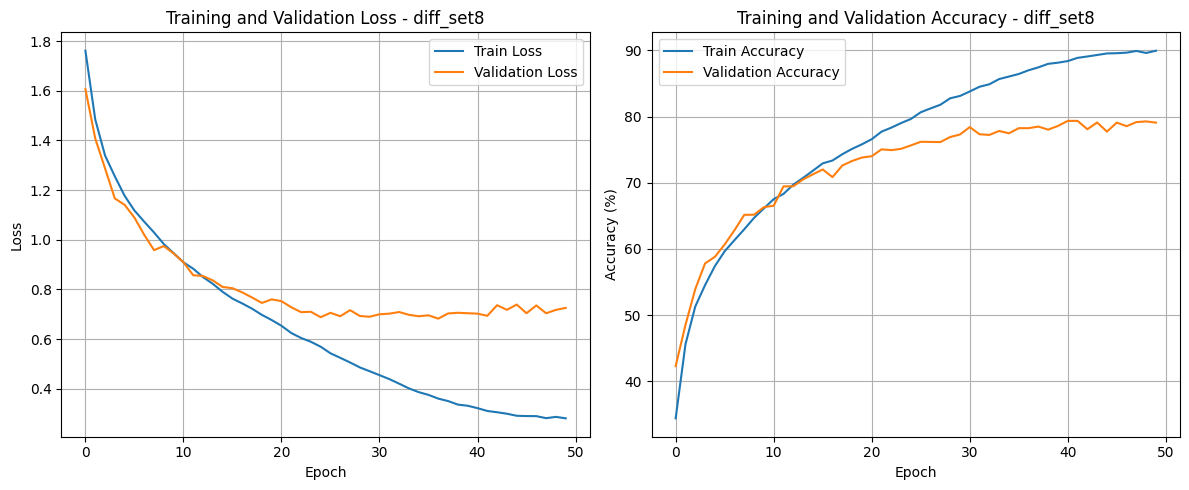


--- Running configuration diff_set9 ---
diff_set9: 7.44M parameters
Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.43it/s, loss=1.7, acc=37.6]


Epoch 1/50:
Train Loss: 1.8556 | Train Acc: 30.32%
Val Loss: 1.7019 | Val Acc: 37.56%
Validation accuracy improved from 0.00% to 37.56%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.52it/s, loss=1.6, acc=40.8]


Epoch 2/50:
Train Loss: 1.6117 | Train Acc: 39.95%
Val Loss: 1.6032 | Val Acc: 40.84%
Validation accuracy improved from 37.56% to 40.84%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.37it/s, loss=1.4, acc=49.5]


Epoch 3/50:
Train Loss: 1.4813 | Train Acc: 45.58%
Val Loss: 1.3972 | Val Acc: 49.50%
Validation accuracy improved from 40.84% to 49.50%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.42it/s, loss=1.36, acc=50.5]


Epoch 4/50:
Train Loss: 1.4035 | Train Acc: 48.86%
Val Loss: 1.3568 | Val Acc: 50.54%
Validation accuracy improved from 49.50% to 50.54%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.40it/s, loss=1.33, acc=52]


Epoch 5/50:
Train Loss: 1.3367 | Train Acc: 51.11%
Val Loss: 1.3259 | Val Acc: 51.98%
Validation accuracy improved from 50.54% to 51.98%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.07it/s, loss=1.2, acc=55.5]


Epoch 6/50:
Train Loss: 1.2914 | Train Acc: 52.73%
Val Loss: 1.2024 | Val Acc: 55.52%
Validation accuracy improved from 51.98% to 55.52%, saving model...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.51it/s, loss=1.21, acc=56.1]


Epoch 7/50:
Train Loss: 1.2505 | Train Acc: 54.35%
Val Loss: 1.2077 | Val Acc: 56.12%
Validation accuracy improved from 55.52% to 56.12%, saving model...


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.46it/s, loss=1.18, acc=58.3]


Epoch 8/50:
Train Loss: 1.2095 | Train Acc: 55.94%
Val Loss: 1.1839 | Val Acc: 58.32%
Validation accuracy improved from 56.12% to 58.32%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.65it/s, loss=1.15, acc=59.4]


Epoch 9/50:
Train Loss: 1.1736 | Train Acc: 57.11%
Val Loss: 1.1510 | Val Acc: 59.36%
Validation accuracy improved from 58.32% to 59.36%, saving model...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.43it/s, loss=1.1, acc=59.3]


Epoch 10/50:
Train Loss: 1.1536 | Train Acc: 58.42%
Val Loss: 1.1030 | Val Acc: 59.34%


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.48it/s, loss=1.1, acc=60.4]


Epoch 11/50:
Train Loss: 1.1240 | Train Acc: 59.20%
Val Loss: 1.0961 | Val Acc: 60.40%
Validation accuracy improved from 59.36% to 60.40%, saving model...


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.32it/s, loss=1.07, acc=61.7]


Epoch 12/50:
Train Loss: 1.0989 | Train Acc: 60.12%
Val Loss: 1.0676 | Val Acc: 61.68%
Validation accuracy improved from 60.40% to 61.68%, saving model...


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.08it/s, loss=1.06, acc=61.7]


Epoch 13/50:
Train Loss: 1.0810 | Train Acc: 60.90%
Val Loss: 1.0632 | Val Acc: 61.70%
Validation accuracy improved from 61.68% to 61.70%, saving model...


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.99it/s, loss=1.03, acc=64]


Epoch 14/50:
Train Loss: 1.0586 | Train Acc: 61.78%
Val Loss: 1.0315 | Val Acc: 64.00%
Validation accuracy improved from 61.70% to 64.00%, saving model...


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.51it/s, loss=1, acc=64.7]


Epoch 15/50:
Train Loss: 1.0366 | Train Acc: 62.49%
Val Loss: 1.0018 | Val Acc: 64.74%
Validation accuracy improved from 64.00% to 64.74%, saving model...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.34it/s, loss=0.968, acc=65.5]


Epoch 16/50:
Train Loss: 1.0164 | Train Acc: 63.38%
Val Loss: 0.9679 | Val Acc: 65.50%
Validation accuracy improved from 64.74% to 65.50%, saving model...


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.55it/s, loss=0.968, acc=65.1]


Epoch 17/50:
Train Loss: 0.9963 | Train Acc: 64.03%
Val Loss: 0.9683 | Val Acc: 65.06%


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.33it/s, loss=0.94, acc=66.5]


Epoch 18/50:
Train Loss: 0.9849 | Train Acc: 64.46%
Val Loss: 0.9402 | Val Acc: 66.52%
Validation accuracy improved from 65.50% to 66.52%, saving model...


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.40it/s, loss=0.956, acc=66.6]


Epoch 19/50:
Train Loss: 0.9661 | Train Acc: 65.14%
Val Loss: 0.9561 | Val Acc: 66.58%
Validation accuracy improved from 66.52% to 66.58%, saving model...


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.37it/s, loss=0.961, acc=66.1]


Epoch 20/50:
Train Loss: 0.9440 | Train Acc: 66.12%
Val Loss: 0.9613 | Val Acc: 66.06%


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.50it/s, loss=0.933, acc=67.3]


Epoch 21/50:
Train Loss: 0.9291 | Train Acc: 66.50%
Val Loss: 0.9335 | Val Acc: 67.30%
Validation accuracy improved from 66.58% to 67.30%, saving model...


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.33it/s, loss=0.926, acc=66.8]


Epoch 22/50:
Train Loss: 0.9156 | Train Acc: 67.05%
Val Loss: 0.9265 | Val Acc: 66.80%


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.29it/s, loss=0.949, acc=66.6]


Epoch 23/50:
Train Loss: 0.8974 | Train Acc: 67.75%
Val Loss: 0.9490 | Val Acc: 66.60%


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.39it/s, loss=0.897, acc=68]


Epoch 24/50:
Train Loss: 0.8880 | Train Acc: 68.21%
Val Loss: 0.8974 | Val Acc: 68.00%
Validation accuracy improved from 67.30% to 68.00%, saving model...


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.11it/s, loss=0.883, acc=69.1]


Epoch 25/50:
Train Loss: 0.8710 | Train Acc: 68.65%
Val Loss: 0.8826 | Val Acc: 69.14%
Validation accuracy improved from 68.00% to 69.14%, saving model...


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.33it/s, loss=0.877, acc=68.8]


Epoch 26/50:
Train Loss: 0.8546 | Train Acc: 69.41%
Val Loss: 0.8773 | Val Acc: 68.76%


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.97it/s, loss=0.882, acc=69.3]


Epoch 27/50:
Train Loss: 0.8420 | Train Acc: 69.52%
Val Loss: 0.8822 | Val Acc: 69.28%
Validation accuracy improved from 69.14% to 69.28%, saving model...


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.17it/s, loss=0.932, acc=68.8]


Epoch 28/50:
Train Loss: 0.8275 | Train Acc: 70.11%
Val Loss: 0.9323 | Val Acc: 68.78%


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.87it/s, loss=0.88, acc=70.7]


Epoch 29/50:
Train Loss: 0.8180 | Train Acc: 70.64%
Val Loss: 0.8796 | Val Acc: 70.68%
Validation accuracy improved from 69.28% to 70.68%, saving model...


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.49it/s, loss=0.854, acc=70.2]


Epoch 30/50:
Train Loss: 0.8063 | Train Acc: 70.94%
Val Loss: 0.8537 | Val Acc: 70.22%


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.28it/s, loss=0.855, acc=70.8]


Epoch 31/50:
Train Loss: 0.7984 | Train Acc: 71.25%
Val Loss: 0.8545 | Val Acc: 70.82%
Validation accuracy improved from 70.68% to 70.82%, saving model...


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.62it/s, loss=0.843, acc=71.4]


Epoch 32/50:
Train Loss: 0.7832 | Train Acc: 71.94%
Val Loss: 0.8428 | Val Acc: 71.38%
Validation accuracy improved from 70.82% to 71.38%, saving model...


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.19it/s, loss=0.861, acc=71.1]


Epoch 33/50:
Train Loss: 0.7694 | Train Acc: 72.37%
Val Loss: 0.8610 | Val Acc: 71.08%


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.45it/s, loss=0.865, acc=70.4]


Epoch 34/50:
Train Loss: 0.7619 | Train Acc: 72.55%
Val Loss: 0.8652 | Val Acc: 70.36%


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.33it/s, loss=0.86, acc=71.4]


Epoch 35/50:
Train Loss: 0.7542 | Train Acc: 72.86%
Val Loss: 0.8600 | Val Acc: 71.36%


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.37it/s, loss=0.839, acc=71.5]


Epoch 36/50:
Train Loss: 0.7431 | Train Acc: 73.16%
Val Loss: 0.8392 | Val Acc: 71.54%
Validation accuracy improved from 71.38% to 71.54%, saving model...


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.36it/s, loss=0.858, acc=70.9]


Epoch 37/50:
Train Loss: 0.7293 | Train Acc: 73.65%
Val Loss: 0.8576 | Val Acc: 70.90%


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.34it/s, loss=0.847, acc=71.6]


Epoch 38/50:
Train Loss: 0.7255 | Train Acc: 73.90%
Val Loss: 0.8474 | Val Acc: 71.64%
Validation accuracy improved from 71.54% to 71.64%, saving model...


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.58it/s, loss=0.859, acc=71.4]


Epoch 39/50:
Train Loss: 0.7138 | Train Acc: 74.24%
Val Loss: 0.8585 | Val Acc: 71.44%


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.73it/s, loss=0.873, acc=71.7]


Epoch 40/50:
Train Loss: 0.7060 | Train Acc: 74.42%
Val Loss: 0.8727 | Val Acc: 71.72%
Validation accuracy improved from 71.64% to 71.72%, saving model...


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.41it/s, loss=0.852, acc=71.4]


Epoch 41/50:
Train Loss: 0.7070 | Train Acc: 74.44%
Val Loss: 0.8524 | Val Acc: 71.44%


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.45it/s, loss=0.843, acc=72]


Epoch 42/50:
Train Loss: 0.6998 | Train Acc: 74.83%
Val Loss: 0.8427 | Val Acc: 71.98%
Validation accuracy improved from 71.72% to 71.98%, saving model...


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.08it/s, loss=0.866, acc=70.4]


Epoch 43/50:
Train Loss: 0.6978 | Train Acc: 74.73%
Val Loss: 0.8657 | Val Acc: 70.44%


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.18it/s, loss=0.852, acc=71.5]


Epoch 44/50:
Train Loss: 0.6919 | Train Acc: 74.95%
Val Loss: 0.8519 | Val Acc: 71.48%


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.44it/s, loss=0.854, acc=72.4]


Epoch 45/50:
Train Loss: 0.6818 | Train Acc: 75.45%
Val Loss: 0.8541 | Val Acc: 72.40%
Validation accuracy improved from 71.98% to 72.40%, saving model...


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.21it/s, loss=0.851, acc=71.6]


Epoch 46/50:
Train Loss: 0.6833 | Train Acc: 75.51%
Val Loss: 0.8514 | Val Acc: 71.56%


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.35it/s, loss=0.867, acc=71.1]


Epoch 47/50:
Train Loss: 0.6784 | Train Acc: 75.69%
Val Loss: 0.8671 | Val Acc: 71.08%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.26it/s, loss=0.846, acc=72.2]


Epoch 48/50:
Train Loss: 0.6782 | Train Acc: 75.66%
Val Loss: 0.8465 | Val Acc: 72.22%


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.51it/s, loss=0.853, acc=71.2]


Epoch 49/50:
Train Loss: 0.6734 | Train Acc: 75.70%
Val Loss: 0.8531 | Val Acc: 71.16%


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.24it/s, loss=0.841, acc=72.2]


Epoch 50/50:
Train Loss: 0.6783 | Train Acc: 75.46%
Val Loss: 0.8406 | Val Acc: 72.24%
Best validation accuracy: 72.40%
Loading best model for evaluation...


Evaluating on test set: 100%|██████████| 79/79 [00:04<00:00, 19.38it/s]


Test accuracy: 72.22%
Final test accuracy: 72.22%
Plotting metrics...


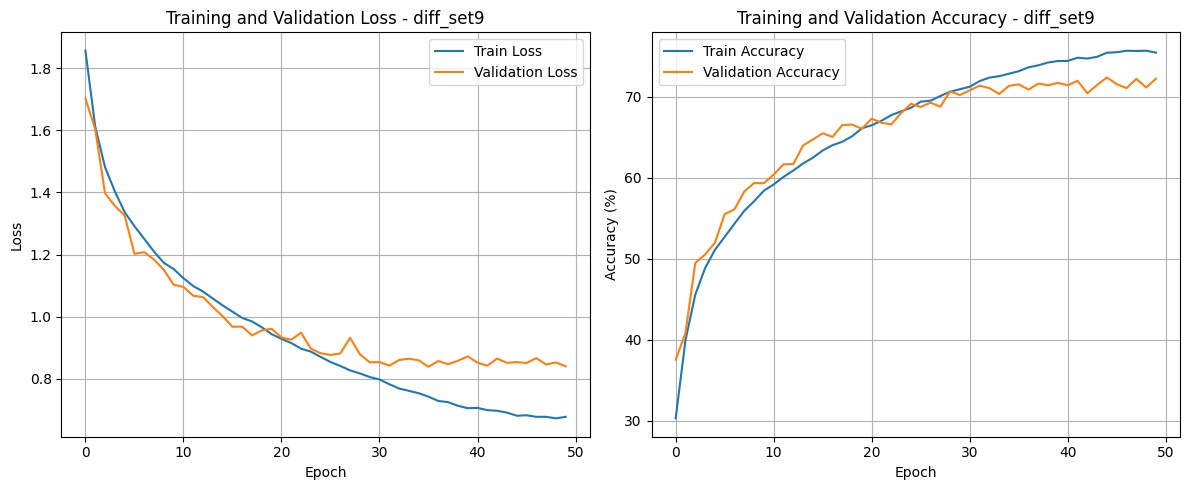


--- Running configuration diff_set10 ---
diff_set10: 11.12M parameters
Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.49it/s, loss=1.68, acc=38.5]


Epoch 1/50:
Train Loss: 1.8346 | Train Acc: 31.38%
Val Loss: 1.6773 | Val Acc: 38.52%
Validation accuracy improved from 0.00% to 38.52%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.04it/s, loss=1.57, acc=43.4]


Epoch 2/50:
Train Loss: 1.5917 | Train Acc: 41.16%
Val Loss: 1.5716 | Val Acc: 43.40%
Validation accuracy improved from 38.52% to 43.40%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.01it/s, loss=1.4, acc=49.5]


Epoch 3/50:
Train Loss: 1.4728 | Train Acc: 46.26%
Val Loss: 1.4026 | Val Acc: 49.48%
Validation accuracy improved from 43.40% to 49.48%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.53it/s, loss=1.35, acc=51]


Epoch 4/50:
Train Loss: 1.3937 | Train Acc: 48.91%
Val Loss: 1.3547 | Val Acc: 51.00%
Validation accuracy improved from 49.48% to 51.00%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.95it/s, loss=1.3, acc=52.4]


Epoch 5/50:
Train Loss: 1.3336 | Train Acc: 51.41%
Val Loss: 1.2990 | Val Acc: 52.40%
Validation accuracy improved from 51.00% to 52.40%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.04it/s, loss=1.23, acc=55.1]


Epoch 6/50:
Train Loss: 1.2819 | Train Acc: 53.51%
Val Loss: 1.2332 | Val Acc: 55.14%
Validation accuracy improved from 52.40% to 55.14%, saving model...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.40it/s, loss=1.2, acc=56.5]


Epoch 7/50:
Train Loss: 1.2417 | Train Acc: 54.96%
Val Loss: 1.2033 | Val Acc: 56.52%
Validation accuracy improved from 55.14% to 56.52%, saving model...


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.98it/s, loss=1.18, acc=57.3]


Epoch 8/50:
Train Loss: 1.1936 | Train Acc: 56.79%
Val Loss: 1.1775 | Val Acc: 57.26%
Validation accuracy improved from 56.52% to 57.26%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.91it/s, loss=1.12, acc=59.7]


Epoch 9/50:
Train Loss: 1.1598 | Train Acc: 58.36%
Val Loss: 1.1157 | Val Acc: 59.74%
Validation accuracy improved from 57.26% to 59.74%, saving model...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.14it/s, loss=1.11, acc=61.3]


Epoch 10/50:
Train Loss: 1.1200 | Train Acc: 59.45%
Val Loss: 1.1092 | Val Acc: 61.28%
Validation accuracy improved from 59.74% to 61.28%, saving model...


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.09it/s, loss=1.07, acc=62]


Epoch 11/50:
Train Loss: 1.0917 | Train Acc: 60.84%
Val Loss: 1.0712 | Val Acc: 62.02%
Validation accuracy improved from 61.28% to 62.02%, saving model...


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.45it/s, loss=1.03, acc=63.2]


Epoch 12/50:
Train Loss: 1.0562 | Train Acc: 62.09%
Val Loss: 1.0331 | Val Acc: 63.22%
Validation accuracy improved from 62.02% to 63.22%, saving model...


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.84it/s, loss=1.02, acc=63.5]


Epoch 13/50:
Train Loss: 1.0184 | Train Acc: 63.31%
Val Loss: 1.0224 | Val Acc: 63.52%
Validation accuracy improved from 63.22% to 63.52%, saving model...


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.44it/s, loss=0.979, acc=63.9]


Epoch 14/50:
Train Loss: 0.9898 | Train Acc: 64.76%
Val Loss: 0.9787 | Val Acc: 63.90%
Validation accuracy improved from 63.52% to 63.90%, saving model...


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.89it/s, loss=1, acc=64.3]


Epoch 15/50:
Train Loss: 0.9629 | Train Acc: 65.50%
Val Loss: 0.9995 | Val Acc: 64.34%
Validation accuracy improved from 63.90% to 64.34%, saving model...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.91it/s, loss=0.961, acc=65.9]


Epoch 16/50:
Train Loss: 0.9373 | Train Acc: 66.54%
Val Loss: 0.9609 | Val Acc: 65.92%
Validation accuracy improved from 64.34% to 65.92%, saving model...


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.15it/s, loss=0.978, acc=65.5]


Epoch 17/50:
Train Loss: 0.9123 | Train Acc: 67.38%
Val Loss: 0.9784 | Val Acc: 65.48%


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.80it/s, loss=0.934, acc=67.7]


Epoch 18/50:
Train Loss: 0.8884 | Train Acc: 68.42%
Val Loss: 0.9337 | Val Acc: 67.68%
Validation accuracy improved from 65.92% to 67.68%, saving model...


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.33it/s, loss=0.906, acc=67.5]


Epoch 19/50:
Train Loss: 0.8617 | Train Acc: 69.32%
Val Loss: 0.9060 | Val Acc: 67.48%


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.99it/s, loss=0.892, acc=68.9]


Epoch 20/50:
Train Loss: 0.8445 | Train Acc: 69.80%
Val Loss: 0.8918 | Val Acc: 68.88%
Validation accuracy improved from 67.68% to 68.88%, saving model...


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.50it/s, loss=0.873, acc=69.5]


Epoch 21/50:
Train Loss: 0.8173 | Train Acc: 70.86%
Val Loss: 0.8725 | Val Acc: 69.48%
Validation accuracy improved from 68.88% to 69.48%, saving model...


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.80it/s, loss=0.898, acc=68.3]


Epoch 22/50:
Train Loss: 0.7979 | Train Acc: 71.56%
Val Loss: 0.8983 | Val Acc: 68.26%


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.42it/s, loss=0.866, acc=69.7]


Epoch 23/50:
Train Loss: 0.7700 | Train Acc: 72.32%
Val Loss: 0.8662 | Val Acc: 69.66%
Validation accuracy improved from 69.48% to 69.66%, saving model...


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.59it/s, loss=0.892, acc=69.3]


Epoch 24/50:
Train Loss: 0.7556 | Train Acc: 73.14%
Val Loss: 0.8921 | Val Acc: 69.32%


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.71it/s, loss=0.84, acc=70.4]


Epoch 25/50:
Train Loss: 0.7272 | Train Acc: 74.14%
Val Loss: 0.8397 | Val Acc: 70.40%
Validation accuracy improved from 69.66% to 70.40%, saving model...


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.07it/s, loss=0.855, acc=70.6]


Epoch 26/50:
Train Loss: 0.7118 | Train Acc: 74.85%
Val Loss: 0.8550 | Val Acc: 70.64%
Validation accuracy improved from 70.40% to 70.64%, saving model...


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.90it/s, loss=0.838, acc=70.2]


Epoch 27/50:
Train Loss: 0.6910 | Train Acc: 75.26%
Val Loss: 0.8384 | Val Acc: 70.18%


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.57it/s, loss=0.821, acc=70.7]


Epoch 28/50:
Train Loss: 0.6719 | Train Acc: 75.92%
Val Loss: 0.8213 | Val Acc: 70.66%
Validation accuracy improved from 70.64% to 70.66%, saving model...


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.06it/s, loss=0.826, acc=72]


Epoch 29/50:
Train Loss: 0.6518 | Train Acc: 76.39%
Val Loss: 0.8259 | Val Acc: 71.98%
Validation accuracy improved from 70.66% to 71.98%, saving model...


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.10it/s, loss=0.841, acc=71.5]


Epoch 30/50:
Train Loss: 0.6356 | Train Acc: 77.07%
Val Loss: 0.8414 | Val Acc: 71.46%


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.22it/s, loss=0.821, acc=71.9]


Epoch 31/50:
Train Loss: 0.6146 | Train Acc: 78.07%
Val Loss: 0.8205 | Val Acc: 71.86%


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.68it/s, loss=0.816, acc=73.2]


Epoch 32/50:
Train Loss: 0.5955 | Train Acc: 78.69%
Val Loss: 0.8160 | Val Acc: 73.24%
Validation accuracy improved from 71.98% to 73.24%, saving model...


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 23.63it/s, loss=0.808, acc=73]


Epoch 33/50:
Train Loss: 0.5777 | Train Acc: 79.34%
Val Loss: 0.8085 | Val Acc: 72.98%


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.38it/s, loss=0.815, acc=72.7]


Epoch 34/50:
Train Loss: 0.5575 | Train Acc: 80.05%
Val Loss: 0.8146 | Val Acc: 72.66%


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.50it/s, loss=0.836, acc=72]


Epoch 35/50:
Train Loss: 0.5465 | Train Acc: 80.44%
Val Loss: 0.8361 | Val Acc: 71.96%


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.97it/s, loss=0.84, acc=72.4]


Epoch 36/50:
Train Loss: 0.5315 | Train Acc: 81.08%
Val Loss: 0.8400 | Val Acc: 72.38%


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.64it/s, loss=0.867, acc=72.5]


Epoch 37/50:
Train Loss: 0.5212 | Train Acc: 81.22%
Val Loss: 0.8666 | Val Acc: 72.46%


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.04it/s, loss=0.842, acc=72.7]


Epoch 38/50:
Train Loss: 0.5086 | Train Acc: 81.85%
Val Loss: 0.8421 | Val Acc: 72.68%


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.11it/s, loss=0.826, acc=73.7]


Epoch 39/50:
Train Loss: 0.4910 | Train Acc: 82.32%
Val Loss: 0.8257 | Val Acc: 73.72%
Validation accuracy improved from 73.24% to 73.72%, saving model...


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.55it/s, loss=0.846, acc=73.5]


Epoch 40/50:
Train Loss: 0.4814 | Train Acc: 82.80%
Val Loss: 0.8462 | Val Acc: 73.50%


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.98it/s, loss=0.833, acc=73.5]


Epoch 41/50:
Train Loss: 0.4724 | Train Acc: 83.12%
Val Loss: 0.8335 | Val Acc: 73.52%


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.11it/s, loss=0.829, acc=73.2]


Epoch 42/50:
Train Loss: 0.4645 | Train Acc: 83.23%
Val Loss: 0.8290 | Val Acc: 73.20%


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.22it/s, loss=0.834, acc=74]


Epoch 43/50:
Train Loss: 0.4567 | Train Acc: 83.71%
Val Loss: 0.8342 | Val Acc: 73.96%
Validation accuracy improved from 73.72% to 73.96%, saving model...


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.79it/s, loss=0.816, acc=74.6]


Epoch 44/50:
Train Loss: 0.4478 | Train Acc: 84.02%
Val Loss: 0.8155 | Val Acc: 74.60%
Validation accuracy improved from 73.96% to 74.60%, saving model...


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.28it/s, loss=0.808, acc=74.8]


Epoch 45/50:
Train Loss: 0.4463 | Train Acc: 83.99%
Val Loss: 0.8084 | Val Acc: 74.76%
Validation accuracy improved from 74.60% to 74.76%, saving model...


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.54it/s, loss=0.817, acc=74.1]


Epoch 46/50:
Train Loss: 0.4387 | Train Acc: 84.29%
Val Loss: 0.8171 | Val Acc: 74.06%


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.38it/s, loss=0.819, acc=74.7]


Epoch 47/50:
Train Loss: 0.4382 | Train Acc: 84.41%
Val Loss: 0.8189 | Val Acc: 74.72%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.17it/s, loss=0.834, acc=73.9]


Epoch 48/50:
Train Loss: 0.4385 | Train Acc: 84.34%
Val Loss: 0.8343 | Val Acc: 73.94%


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 22.16it/s, loss=0.839, acc=74.1]


Epoch 49/50:
Train Loss: 0.4309 | Train Acc: 84.43%
Val Loss: 0.8386 | Val Acc: 74.06%


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:01<00:00, 21.60it/s, loss=0.837, acc=74]


Epoch 50/50:
Train Loss: 0.4339 | Train Acc: 84.41%
Val Loss: 0.8368 | Val Acc: 74.04%
Best validation accuracy: 74.76%
Loading best model for evaluation...


Evaluating on test set: 100%|██████████| 79/79 [00:03<00:00, 25.74it/s]


Test accuracy: 74.96%
Final test accuracy: 74.96%
Plotting metrics...


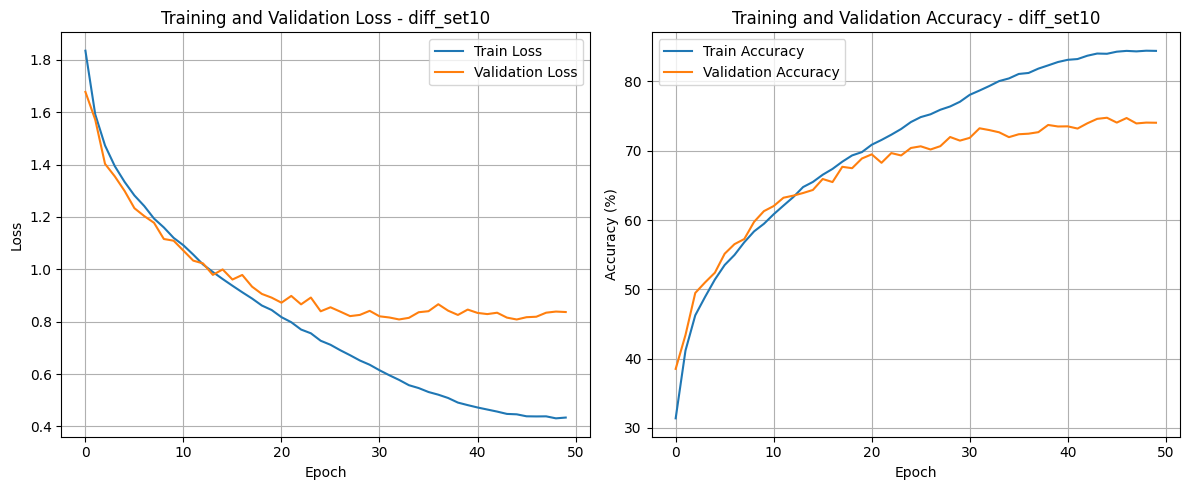


All results saved to diff_vit_hyperparam_results.csv

Best configuration:
Configuration ID: diff_set8
Test Accuracy: 79.69%
Parameters: d_model=192, num_heads=4, num_layers=8, dim_ff=768, dropout=0.1, patch_size=4, lambda=0.5


In [2]:

"""Main function for hyperparameter tuning of Differential Vision Transformer"""
print("Setting up Differential Vision Transformer hyperparameter tuning...")

hyperparams_list = [
    {"d_model": 192, "num_heads": 8, "num_layers": 8, "dim_ff": 768, "dropout": 0.1},
    {"d_model": 192, "num_heads": 6, "num_layers": 8, "dim_ff": 768, "dropout": 0.1, "patch_size": 8},
    {"d_model": 128, "num_heads": 4, "num_layers": 6, "dim_ff": 512, "dropout": 0.1},
    {"d_model": 256, "num_heads": 8, "num_layers": 10, "dim_ff": 1024, "dropout": 0.1},
    {"d_model": 128, "num_heads": 4, "num_layers": 8, "dim_ff": 1024, "dropout": 0.1},
    {"d_model": 128, "num_heads": 4, "num_layers": 12, "dim_ff": 768, "dropout": 0.1},
    {"d_model": 192, "num_heads": 8, "num_layers": 8, "dim_ff": 768, "dropout": 0.3},
    {"d_model": 192, "num_heads": 4, "num_layers": 8, "dim_ff": 768, "dropout": 0.1},
    {"d_model": 192, "num_heads": 6, "num_layers": 12, "dim_ff": 1024, "dropout": 0.3},
    {"d_model": 256, "num_heads": 8, "num_layers": 12, "dim_ff": 1024, "dropout": 0.1, "patch_size": 8},
]

import pandas as pd
from copy import deepcopy
import torch

results = []

batch_size = 128
epochs = 50
lr = 3e-4
weight_decay = 1e-4
lambda_init = 0.5  # Default lambda value for differential attention

train_loader, val_loader, test_loader = get_data_loaders(batch_size)

for i, params in enumerate(hyperparams_list):
    tag = f"diff_set{i+1}"
    print(f"\n--- Running configuration {tag} ---")
    config = deepcopy(params)
    patch_size = config.pop("patch_size", 4)  # Default patch size is 4
    
    # Create differential ViT model with the current hyperparameters
    model = DifferentialVisionTransformer(
        image_size=32,
        patch_size=patch_size,
        in_channels=3,
        num_classes=10,
        lambda_init=lambda_init,
        **config
    )
    
    print(f"{tag}: {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters")
    
    # Train and save best model
    train_losses, train_accs, val_losses, val_accs = train_model(
        model, train_loader, val_loader,
        epochs=epochs,
        lr=lr,
        weight_decay=weight_decay,
        model_name=tag  # Use tag as model name for saving
    )
    
    # Load best model for evaluation
    print("Loading best model for evaluation...")
    best_model = DifferentialVisionTransformer(
        image_size=32,
        patch_size=patch_size,
        in_channels=3,
        num_classes=10,
        lambda_init=lambda_init,
        **config
    )
    best_model.load_state_dict(torch.load(f'best_model_{tag}.pth'))
    
    # Evaluate the model
    test_acc = evaluate_model(best_model, test_loader)
    print(f"Final test accuracy: {test_acc:.2f}%")
    
    print("Plotting metrics...")
    plot_metrics(train_losses, val_losses, train_accs, val_accs, title_suffix=f" - {tag}", filename_prefix=tag)
    
    # Record results
    results.append({
        "config_id": tag,
        "d_model": config["d_model"],
        "num_heads": config["num_heads"], 
        "num_layers": config["num_layers"],
        "dim_ff": config["dim_ff"],
        "dropout": config["dropout"],
        "patch_size": patch_size,
        "lambda": lambda_init,
        "train_acc": train_accs[-1],
        "val_acc": val_accs[-1],
        "test_acc": test_acc
    })

# Save all results to CSV
df = pd.DataFrame(results)
df.to_csv("diff_vit_hyperparam_results.csv", index=False)
print("\nAll results saved to diff_vit_hyperparam_results.csv")

# Find and print the best configuration
best_idx = df["test_acc"].idxmax()
best_config = df.iloc[best_idx]
print("\nBest configuration:")
print(f"Configuration ID: {best_config['config_id']}")
print(f"Test Accuracy: {best_config['test_acc']:.2f}%")
print(f"Parameters: d_model={best_config['d_model']}, num_heads={best_config['num_heads']}, "
      f"num_layers={best_config['num_layers']}, dim_ff={best_config['dim_ff']}, "
      f"dropout={best_config['dropout']}, patch_size={best_config['patch_size']}, lambda={best_config['lambda']}")

